In [2]:
import copy
import torch
import random
import torchvision
import numpy as np
from PIL import Image
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.models import resnet18
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

## Step1 Train FFN

For this step, I trained a FFN and save the model as .pt file.

In [4]:
train_dataset = datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())

In [13]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        # features = x
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

def resnet18():
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=10,
                   grayscale=True)
    return model

In [9]:
model=resnet18().cuda()
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-6, momentum = 0.9,nesterov = True)
criterion=nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [43]:
epochs = 20
train_losses, test_losses = [], []
for i in range(epochs):
    for _,data in enumerate(train_loader):
        model.train()
        img, labels = data
        img = img.cuda()
        labels = labels.cuda()
        logits, probas = model(img)
        loss = criterion(logits,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        total = len(test_dataset)
        correct = 0
        for _,(img,labels) in enumerate(test_loader):
            imgs = img.cuda()
            labels = labels.cuda()
            logits, probas = model(imgs)
            _, predicted_labels = torch.max(probas, 1)
#             num_examples += labels.size(0)
            correct += (predicted_labels == labels).sum()
        print('epoch: {}'.format(i),
              'training loss: {}'.format(loss.item()),
              'testing acc: {}'.format(correct.item()/total))           

epoch: 0 training loss: 0.5211280584335327 testing acc: 0.9883


KeyboardInterrupt: 

In [70]:
# save model
torch.save(model, './model_checkpoint/ResNet.pt')

/nas/home/duyongka/.conda/envs/async/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/nas/home/duyongka/.conda/envs/async/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
# load model
model = torch.load('./model_checkpoint/ResNet.pt')
model = model.cuda()

## Step2 Select Informative Image

I tried to implement the maximizing entropy, but I am confused about the constraint under in this case.

It seems like images with ditinctive features are better for training generative model. 

Thus, I manually selected images from the dataset.

In [16]:
selected_sample = []
for i in range(10):
    img = Image.open('./sample/sample_'+str(i)+'.png')
    pixels = img.load()
    to_tensor = transforms.ToTensor()
    to_gray = transforms.Grayscale(num_output_channels=1)
    img = to_tensor(to_gray(img))
    selected_sample.append(img)

selected_logits = []
for sample in selected_sample:
    logit,_ = model(sample.view(1,1,28,28).cuda())
    selected_logits.append(logit)

## Step3 Data Augmentation

After selecting the image, I designed three data augmentation methods, because
some transformations are only useful for certain numbers while meaningless for 
the others.

Basic transform is for nonsemetric number such as 2,4,5,6,7,9.

HV (horizontal and vertical) transform is for numbers such as 0,1,8.

V (vertical) transform is for number such as 3.

In [6]:
def img_show(img):
    plt.imshow(img[0], cmap=plt.get_cmap('gray'))
    plt.show()

In [17]:
basic_transform = transforms.Compose(
                    [
                        transforms.ToPILImage(),
                        #transforms.RandomRotation(degrees=(10, -10), fill=(0,)),
                        transforms.RandomAffine(degrees=(15, -15), translate=(0.1,0.1), scale=(0.8, 1.1)),
                        transforms.ToTensor()
                    ])
# 0,1,8
HV_transform = transforms.Compose(
                    [
                        transforms.ToPILImage(),
                        transforms.RandomHorizontalFlip(p=0.4),
                        transforms.RandomVerticalFlip(p=0.3),
                        transforms.RandomAffine(degrees=(15, -15), translate=(0.1,0.1), scale=(0.8, 1.1)),
                        transforms.ToTensor()
                    ])
# 3
V_transform = transforms.Compose(
                    [
                        transforms.ToPILImage(),
                        transforms.RandomVerticalFlip(p=0.4),
                        transforms.RandomAffine(degrees=(15, -15), translate=(0.1,0.1), scale=(0.8, 1.1)),
                        transforms.ToTensor()
                    ])

In [18]:
# get augmentation data
aug_data = []

for label,img in enumerate(selected_sample):
    aug_data.append([img,label])
    transform = basic_transform
    if label in [0,1,8]:
        transform = HV_transform
    elif label == 3:
        transform = V_transform
    for i in range(400):
        aug_data.append([transform(img),label])

# add more data up to 4096
while len(aug_data)%1024 != 0:
    for label,img in enumerate(selected_sample):
        transform = basic_transform
        if label in [0,1,8]:
            transform = HV_transform
        elif label == 3:
            transform = V_transform
        aug_data.append([transform(img),label])
        if len(aug_data)%1024 == 0:
            break

## Step4 Train CGAN

For this part, I implemented a conditional GAN with FFN to generate fake image.

Input: random vector + label
Output: image from label class

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [10]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [13]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
train_loader = DataLoader(aug_dataset(aug_data), batch_size=128, shuffle=True)
train_loader_real = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [14]:
def discriminator_train_step(batch_size, real_images, labels):
    d_optimizer.zero_grad()
    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [15]:
def generator_train_step(batch_size, real_images):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    # swd loss
    # g_loss += swd(fake_images, real_images.view(batch_size, 28, 28))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

epoch: 0 g_loss: 3.7884304523468018 d_loss: 0.08162419001261394


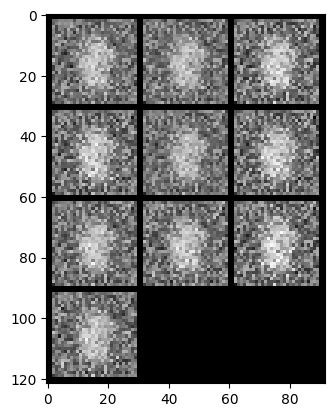

epoch: 1 g_loss: 5.767476558685303 d_loss: 0.03664021193981171
epoch: 2 g_loss: 9.067819595336914 d_loss: 0.0030161446581284204
epoch: 3 g_loss: 9.219915390014648 d_loss: 0.008921322723229727
epoch: 4 g_loss: 5.864265441894531 d_loss: 0.018670974920193355
epoch: 5 g_loss: 6.722437858581543 d_loss: 0.059107497334480286
epoch: 6 g_loss: 6.257575988769531 d_loss: 0.05242090920607249
epoch: 7 g_loss: 6.647050857543945 d_loss: 0.0073509663343429565
epoch: 8 g_loss: 6.606901168823242 d_loss: 0.01438286155462265
epoch: 9 g_loss: 6.075910568237305 d_loss: 0.023711470266183216
epoch: 10 g_loss: 7.0857038497924805 d_loss: 0.01193134238322576
epoch: 11 g_loss: 9.292675018310547 d_loss: 0.004897035037477811
epoch: 12 g_loss: 6.324732780456543 d_loss: 0.0040892623364925385
epoch: 13 g_loss: 10.41193962097168 d_loss: 0.012911271303892136
epoch: 14 g_loss: 8.857756614685059 d_loss: 0.01230208327372869
epoch: 15 g_loss: 12.271160125732422 d_loss: 0.0004907431236157814
epoch: 16 g_loss: 13.320234298706

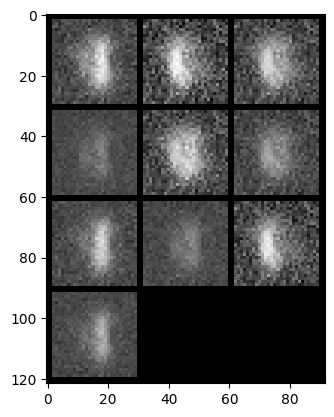

epoch: 21 g_loss: 7.684688091278076 d_loss: 0.006386733303467433
epoch: 22 g_loss: 9.715968132019043 d_loss: 0.026425061126550037
epoch: 23 g_loss: 8.843184471130371 d_loss: 0.012381056944529215
epoch: 24 g_loss: 11.029214859008789 d_loss: 0.0022017008935411773
epoch: 25 g_loss: 11.922258377075195 d_loss: 0.006002284586429596
epoch: 26 g_loss: 10.167530059814453 d_loss: 0.0014014642996092637
epoch: 27 g_loss: 8.386327743530273 d_loss: 0.017760748664538067
epoch: 28 g_loss: 9.983968734741211 d_loss: 0.004380681241552035
epoch: 29 g_loss: 8.054071426391602 d_loss: 0.01036825900276502
epoch: 30 g_loss: 11.10816764831543 d_loss: 0.0039737339441974955
epoch: 31 g_loss: 12.32372760772705 d_loss: 0.0038666737576325736
epoch: 32 g_loss: 14.167012214660645 d_loss: 0.002746414082745711
epoch: 33 g_loss: 9.664133071899414 d_loss: 0.0036886309583981833
epoch: 34 g_loss: 6.220365524291992 d_loss: 0.009356862554947535
epoch: 35 g_loss: 8.481786727905273 d_loss: 0.0005814944549153248
epoch: 36 g_loss

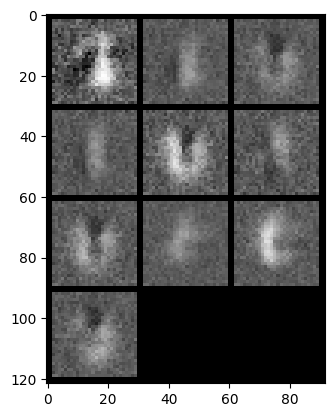

epoch: 41 g_loss: 12.712322235107422 d_loss: 0.010213085760672888
epoch: 42 g_loss: 11.351027488708496 d_loss: 0.001120012563963731
epoch: 43 g_loss: 9.896869659423828 d_loss: 0.00589136965572834
epoch: 44 g_loss: 8.346393585205078 d_loss: 0.001989938939611117
epoch: 45 g_loss: 8.426668167114258 d_loss: 0.0022782178906102977
epoch: 46 g_loss: 11.239514350891113 d_loss: 0.006387431174516678
epoch: 47 g_loss: 10.442025184631348 d_loss: 0.0018533868715167046
epoch: 48 g_loss: 10.213510513305664 d_loss: 0.004968991192678611
epoch: 49 g_loss: 12.007831573486328 d_loss: 0.002357295403877894
epoch: 50 g_loss: 10.904664039611816 d_loss: 0.006530911351243655
epoch: 51 g_loss: 12.218940734863281 d_loss: 0.00018246960826218128
epoch: 52 g_loss: 10.674782752990723 d_loss: 0.0014915444577733676
epoch: 53 g_loss: 10.470908164978027 d_loss: 0.003478533277908961
epoch: 54 g_loss: 8.725090026855469 d_loss: 0.0030307055761416755
epoch: 55 g_loss: 10.265787124633789 d_loss: 0.002240551790843407
epoch: 56

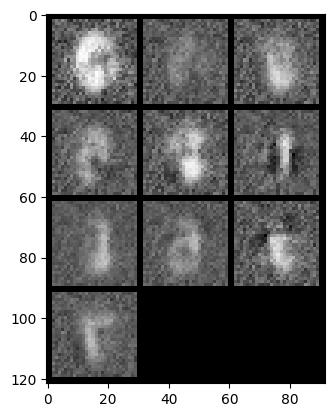

epoch: 61 g_loss: 15.113913536071777 d_loss: 0.0004445642698556185
epoch: 62 g_loss: 10.811704635620117 d_loss: 0.00392470508813858
epoch: 63 g_loss: 9.822622299194336 d_loss: 0.002819551465411981
epoch: 64 g_loss: 12.595291137695312 d_loss: 0.003925794114669164
epoch: 65 g_loss: 11.722343444824219 d_loss: 0.013511029382546743
epoch: 66 g_loss: 12.799646377563477 d_loss: 0.0020557927588621774
epoch: 67 g_loss: 11.41331672668457 d_loss: 0.014478678504625956
epoch: 68 g_loss: 13.40700912475586 d_loss: 0.001151324560244878
epoch: 69 g_loss: 11.949996948242188 d_loss: 0.014668534199396769
epoch: 70 g_loss: 11.354765892028809 d_loss: 0.002288567212720712
epoch: 71 g_loss: 11.567961692810059 d_loss: 0.0027934697767098746
epoch: 72 g_loss: 11.116506576538086 d_loss: 0.005263086408376694
epoch: 73 g_loss: 10.946471214294434 d_loss: 0.011754166334867477
epoch: 74 g_loss: 8.76156234741211 d_loss: 0.007735367864370346
epoch: 75 g_loss: 11.106958389282227 d_loss: 0.005678637574116389
epoch: 76 g_l

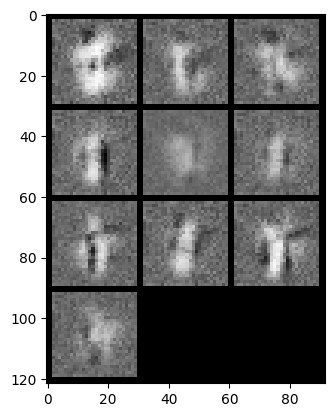

epoch: 81 g_loss: 14.071881294250488 d_loss: 0.0009212777949869633
epoch: 82 g_loss: 10.372211456298828 d_loss: 0.007672275726993878
epoch: 83 g_loss: 12.867897033691406 d_loss: 0.0005563242981831232
epoch: 84 g_loss: 12.409789085388184 d_loss: 0.002556883885214726
epoch: 85 g_loss: 11.096890449523926 d_loss: 0.006425522888700168
epoch: 86 g_loss: 9.501701354980469 d_loss: 0.01137883464495341
epoch: 87 g_loss: 12.825175285339355 d_loss: 0.0018499158322811127
epoch: 88 g_loss: 13.733967781066895 d_loss: 0.008946492026249567
epoch: 89 g_loss: 11.883398056030273 d_loss: 0.017385568469762802
epoch: 90 g_loss: 11.024539947509766 d_loss: 0.0060137224694093066
epoch: 91 g_loss: 12.612022399902344 d_loss: 0.009125216553608576
epoch: 92 g_loss: 11.292287826538086 d_loss: 0.0054835838576157885
epoch: 93 g_loss: 12.152427673339844 d_loss: 0.00788743793964386
epoch: 94 g_loss: 13.20257568359375 d_loss: 0.001047930835435788
epoch: 95 g_loss: 12.33559513092041 d_loss: 0.006732522199551265
epoch: 96 

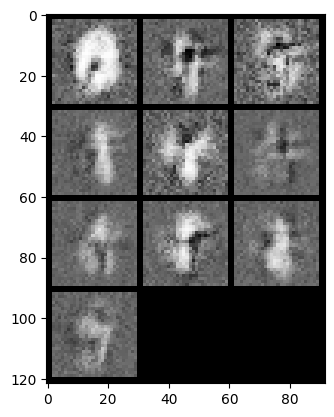

epoch: 101 g_loss: 10.954769134521484 d_loss: 0.001097042579203844
epoch: 102 g_loss: 12.730833053588867 d_loss: 0.001344695221632719
epoch: 103 g_loss: 12.08515739440918 d_loss: 0.004280239964524905
epoch: 104 g_loss: 12.205116271972656 d_loss: 0.0005209757946431637
epoch: 105 g_loss: 10.064709663391113 d_loss: 0.0026707478488485017
epoch: 106 g_loss: 11.282268524169922 d_loss: 0.007963394125302633
epoch: 107 g_loss: 12.3744478225708 d_loss: 0.004440064852436383
epoch: 108 g_loss: 11.42561149597168 d_loss: 0.0024951881108184657
epoch: 109 g_loss: 14.252765655517578 d_loss: 0.003215897207458814
epoch: 110 g_loss: 11.636157989501953 d_loss: 0.0035838199158509574
epoch: 111 g_loss: 9.869555473327637 d_loss: 0.0016727450614174206
epoch: 112 g_loss: 10.224767684936523 d_loss: 0.02200574427843094
epoch: 113 g_loss: 13.638053894042969 d_loss: 0.0061357698092858
epoch: 114 g_loss: 13.086366653442383 d_loss: 0.01196864495674769
epoch: 115 g_loss: 10.733658790588379 d_loss: 0.002771849433581034

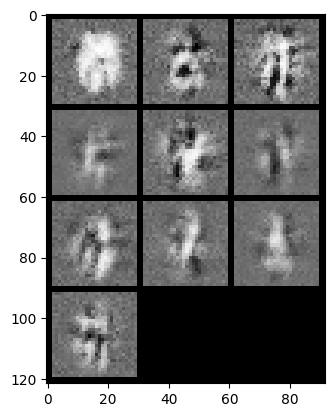

epoch: 121 g_loss: 11.369848251342773 d_loss: 0.018501944839954376
epoch: 122 g_loss: 10.423470497131348 d_loss: 0.0012108801553646724
epoch: 123 g_loss: 12.428953170776367 d_loss: 0.023999348282814026
epoch: 124 g_loss: 13.777538299560547 d_loss: 0.0013939887285232544
epoch: 125 g_loss: 17.240325927734375 d_loss: 0.030545664330323536
epoch: 126 g_loss: 13.72413444519043 d_loss: 0.008139905830224356
epoch: 127 g_loss: 12.064037322998047 d_loss: 0.002631487945715586
epoch: 128 g_loss: 13.457629203796387 d_loss: 0.005753705898920695
epoch: 129 g_loss: 11.341451644897461 d_loss: 0.0014255580802758534
epoch: 130 g_loss: 10.606959342956543 d_loss: 0.013229890416065851
epoch: 131 g_loss: 12.174901008605957 d_loss: 0.027700304985046387
epoch: 132 g_loss: 10.529626846313477 d_loss: 0.008675364156564077
epoch: 133 g_loss: 14.912339210510254 d_loss: 0.01453975091377894
epoch: 134 g_loss: 12.537081718444824 d_loss: 0.0026336036001642547
epoch: 135 g_loss: 11.151870727539062 d_loss: 0.011715605854

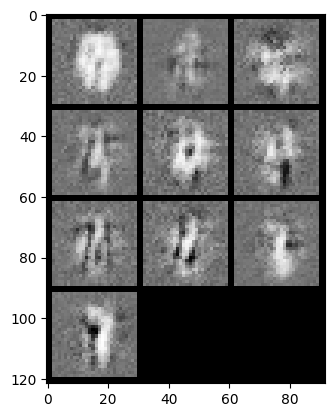

epoch: 141 g_loss: 11.917370796203613 d_loss: 0.006356960162520409
epoch: 142 g_loss: 9.948122024536133 d_loss: 0.003413483500480652
epoch: 143 g_loss: 10.343341827392578 d_loss: 0.00940375899275144
epoch: 144 g_loss: 9.900605201721191 d_loss: 0.011583983898162842
epoch: 145 g_loss: 10.2388916015625 d_loss: 0.0014782639530797799
epoch: 146 g_loss: 10.317994117736816 d_loss: 0.002477987358967463
epoch: 147 g_loss: 12.798118591308594 d_loss: 0.0013202250314255555
epoch: 148 g_loss: 11.75435733795166 d_loss: 0.00824932319422563
epoch: 149 g_loss: 12.996217727661133 d_loss: 0.01369295765956243
epoch: 150 g_loss: 12.91238021850586 d_loss: 0.0011998172849416733
epoch: 151 g_loss: 12.313114166259766 d_loss: 0.002782813273370266
epoch: 152 g_loss: 11.690519332885742 d_loss: 0.0012112956804533799
epoch: 153 g_loss: 11.613147735595703 d_loss: 0.0024847773214181266
epoch: 154 g_loss: 10.997770309448242 d_loss: 0.00309938316543897
epoch: 155 g_loss: 11.95423412322998 d_loss: 0.0030477363616228104


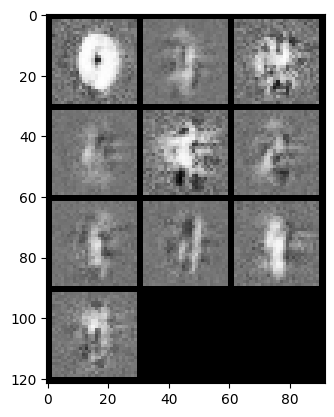

epoch: 161 g_loss: 10.796853065490723 d_loss: 0.0011358393045763175
epoch: 162 g_loss: 15.29736042022705 d_loss: 0.009291479364037514
epoch: 163 g_loss: 11.375448226928711 d_loss: 0.009985456864039103
epoch: 164 g_loss: 16.552350997924805 d_loss: 0.012293022125959396
epoch: 165 g_loss: 13.053665161132812 d_loss: 0.006853440776467323
epoch: 166 g_loss: 11.29587173461914 d_loss: 0.0022431861919661364
epoch: 167 g_loss: 14.807332992553711 d_loss: 0.006174057101209958
epoch: 168 g_loss: 10.606781005859375 d_loss: 0.008386242513855299
epoch: 169 g_loss: 10.132192611694336 d_loss: 0.002002656925469637
epoch: 170 g_loss: 10.553614616394043 d_loss: 0.0034361441309253373
epoch: 171 g_loss: 10.541704177856445 d_loss: 0.03144110987583796
epoch: 172 g_loss: 12.059785842895508 d_loss: 0.04059928903977076
epoch: 173 g_loss: 12.4321870803833 d_loss: 0.005183933923641841
epoch: 174 g_loss: 12.920703887939453 d_loss: 0.0012091641159107287
epoch: 175 g_loss: 13.255622863769531 d_loss: 0.0010691345669329

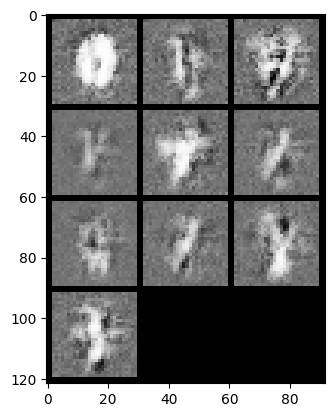

epoch: 181 g_loss: 12.952545166015625 d_loss: 0.0016391025856137276
epoch: 182 g_loss: 11.706839561462402 d_loss: 0.0009499581841131052
epoch: 183 g_loss: 12.153794288635254 d_loss: 0.0023393919691443443
epoch: 184 g_loss: 11.677648544311523 d_loss: 0.009626459330320358
epoch: 185 g_loss: 11.045076370239258 d_loss: 0.00554891179005305
epoch: 186 g_loss: 13.64932632446289 d_loss: 0.000794222035134832
epoch: 187 g_loss: 11.245847702026367 d_loss: 0.006626922637224197
epoch: 188 g_loss: 11.21414566040039 d_loss: 0.00625550498565038
epoch: 189 g_loss: 10.573046684265137 d_loss: 0.0010436012720068295
epoch: 190 g_loss: 10.541526794433594 d_loss: 0.0013866390412052472
epoch: 191 g_loss: 10.296768188476562 d_loss: 0.0006438990434010824
epoch: 192 g_loss: 12.234025955200195 d_loss: 0.017507956673701603
epoch: 193 g_loss: 12.144981384277344 d_loss: 0.01730603848894437
epoch: 194 g_loss: 10.947444915771484 d_loss: 0.0019202049200733502
epoch: 195 g_loss: 11.761959075927734 d_loss: 0.005127461627

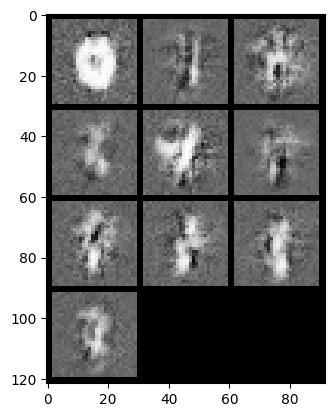

epoch: 201 g_loss: 9.582147598266602 d_loss: 0.0022600103790561357
epoch: 202 g_loss: 11.388032913208008 d_loss: 0.0005563176237046719
epoch: 203 g_loss: 12.979290008544922 d_loss: 0.005292975654204686
epoch: 204 g_loss: 11.61418342590332 d_loss: 0.002147912668685118
epoch: 205 g_loss: 10.952736854553223 d_loss: 0.002268382658561071
epoch: 206 g_loss: 11.062021255493164 d_loss: 0.007308812191088994
epoch: 207 g_loss: 9.41125202178955 d_loss: 0.0004824023538579543
epoch: 208 g_loss: 13.06192398071289 d_loss: 0.0028632267688711486
epoch: 209 g_loss: 11.619087219238281 d_loss: 0.005476926142970721
epoch: 210 g_loss: 11.97085189819336 d_loss: 0.003728157219787439
epoch: 211 g_loss: 10.305121421813965 d_loss: 0.02235560119152069
epoch: 212 g_loss: 11.333003997802734 d_loss: 0.0018266669164101283
epoch: 213 g_loss: 12.026529312133789 d_loss: 0.004909319803118706
epoch: 214 g_loss: 13.079805374145508 d_loss: 0.0006553064255664746
epoch: 215 g_loss: 12.32999038696289 d_loss: 0.0008696083289881

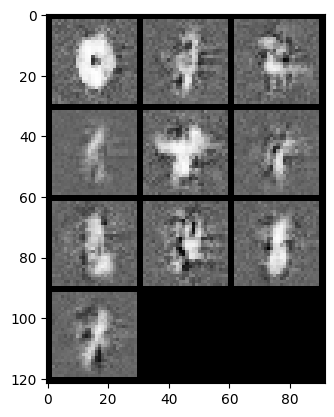

epoch: 221 g_loss: 10.43655014038086 d_loss: 0.0015271998321016629
epoch: 222 g_loss: 11.916086196899414 d_loss: 0.015470211704572042
epoch: 223 g_loss: 12.375057220458984 d_loss: 0.002142909293373426
epoch: 224 g_loss: 13.52995491027832 d_loss: 0.0005391500890254974
epoch: 225 g_loss: 10.883590698242188 d_loss: 0.003947343056400617
epoch: 226 g_loss: 9.743474006652832 d_loss: 0.0027299998328089714
epoch: 227 g_loss: 9.312626838684082 d_loss: 0.007806575546662013
epoch: 228 g_loss: 10.336957931518555 d_loss: 0.0028805950035651526
epoch: 229 g_loss: 9.086520195007324 d_loss: 0.009314830104509989
epoch: 230 g_loss: 11.063323974609375 d_loss: 0.01959444706638654
epoch: 231 g_loss: 11.57899284362793 d_loss: 0.0007753504905849695
epoch: 232 g_loss: 12.090131759643555 d_loss: 0.0021716427678863206
epoch: 233 g_loss: 9.317916870117188 d_loss: 0.004668612654010455
epoch: 234 g_loss: 9.758163452148438 d_loss: 0.00151132233440876
epoch: 235 g_loss: 12.923455238342285 d_loss: 0.002510133199393749

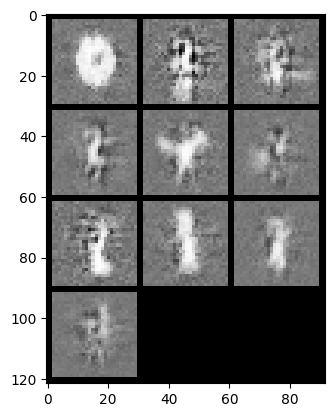

epoch: 241 g_loss: 10.303239822387695 d_loss: 0.0008790261733035246
epoch: 242 g_loss: 10.887489318847656 d_loss: 0.00140709662809968
epoch: 243 g_loss: 12.232400894165039 d_loss: 0.013208394249280294
epoch: 244 g_loss: 10.821585655212402 d_loss: 0.008794694518049559
epoch: 245 g_loss: 10.024799346923828 d_loss: 0.0066263191401958466
epoch: 246 g_loss: 10.33431625366211 d_loss: 0.0016222049792607625
epoch: 247 g_loss: 10.040834426879883 d_loss: 0.0014279624447226524
epoch: 248 g_loss: 10.233203887939453 d_loss: 0.0021569629510243735
epoch: 249 g_loss: 9.750547409057617 d_loss: 0.012789233277241388
epoch: 250 g_loss: 10.156362533569336 d_loss: 0.0033364503954847655
epoch: 251 g_loss: 11.414382934570312 d_loss: 0.002377126986781756
epoch: 252 g_loss: 9.523660659790039 d_loss: 0.010648168623447418
epoch: 253 g_loss: 10.094765663146973 d_loss: 0.01266909639040629
epoch: 254 g_loss: 10.657369613647461 d_loss: 0.0012730998763193686
epoch: 255 g_loss: 11.556434631347656 d_loss: 0.002518125809

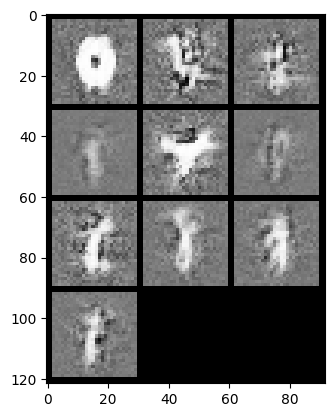

epoch: 261 g_loss: 10.208236694335938 d_loss: 0.017630406965812046
epoch: 262 g_loss: 11.253073692321777 d_loss: 0.01291265587011973
epoch: 263 g_loss: 9.603439331054688 d_loss: 0.014366521189610163
epoch: 264 g_loss: 11.925382614135742 d_loss: 0.01036532719930013
epoch: 265 g_loss: 11.427220344543457 d_loss: 0.006705907483895619
epoch: 266 g_loss: 10.36192512512207 d_loss: 0.011166928956906
epoch: 267 g_loss: 12.449213027954102 d_loss: 0.0029744071265061698
epoch: 268 g_loss: 10.035215377807617 d_loss: 0.0033530391131838164
epoch: 269 g_loss: 10.146900177001953 d_loss: 0.00491925763587157
epoch: 270 g_loss: 10.289329528808594 d_loss: 0.025382233162720997
epoch: 271 g_loss: 10.716730117797852 d_loss: 0.006453162059187889
epoch: 272 g_loss: 10.084712028503418 d_loss: 0.00023114126330862442
epoch: 273 g_loss: 9.463269233703613 d_loss: 0.00720611959695816
epoch: 274 g_loss: 8.316568374633789 d_loss: 0.00223097779477636
epoch: 275 g_loss: 13.858299255371094 d_loss: 0.005006091669201851
epo

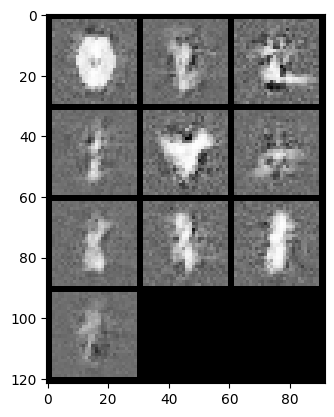

epoch: 281 g_loss: 10.11622142791748 d_loss: 0.00281598853568236
epoch: 282 g_loss: 8.599727630615234 d_loss: 0.004114798891047637
epoch: 283 g_loss: 8.699566841125488 d_loss: 0.013743830223878225
epoch: 284 g_loss: 10.622825622558594 d_loss: 0.0019442643970251083
epoch: 285 g_loss: 10.429286003112793 d_loss: 0.007210667555530866
epoch: 286 g_loss: 10.519510269165039 d_loss: 0.0009553165485461553
epoch: 287 g_loss: 9.860769271850586 d_loss: 0.019780104358990986
epoch: 288 g_loss: 11.806350708007812 d_loss: 0.005372268458207448
epoch: 289 g_loss: 10.230520248413086 d_loss: 0.0027188981572786966
epoch: 290 g_loss: 9.571898460388184 d_loss: 0.0017610245073835056
epoch: 291 g_loss: 9.751343727111816 d_loss: 0.0034178017328182855
epoch: 292 g_loss: 9.411653518676758 d_loss: 0.009370757887760798
epoch: 293 g_loss: 11.478161811828613 d_loss: 0.003620141806701819
epoch: 294 g_loss: 10.940604209899902 d_loss: 0.01632205645243327
epoch: 295 g_loss: 9.721247673034668 d_loss: 0.006173801297942798


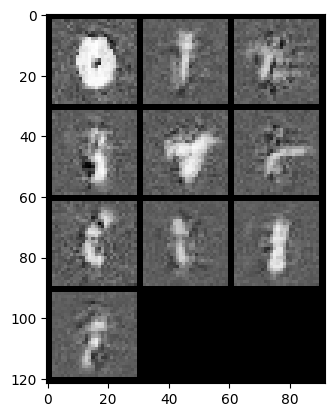

epoch: 301 g_loss: 10.720884323120117 d_loss: 0.002933900182445844
epoch: 302 g_loss: 11.247142791748047 d_loss: 0.001813580592473348
epoch: 303 g_loss: 9.196548461914062 d_loss: 0.017204926659663517
epoch: 304 g_loss: 10.657384872436523 d_loss: 0.003925214211146037
epoch: 305 g_loss: 10.433679580688477 d_loss: 0.005976897353927295
epoch: 306 g_loss: 9.784603118896484 d_loss: 0.003398078183333079
epoch: 307 g_loss: 10.236068725585938 d_loss: 0.007834088678161303
epoch: 308 g_loss: 10.026620864868164 d_loss: 0.01781489948431651
epoch: 309 g_loss: 10.341670989990234 d_loss: 0.0018105798711379368
epoch: 310 g_loss: 11.262557983398438 d_loss: 0.005355203524231911
epoch: 311 g_loss: 13.3640775680542 d_loss: 0.02336016297340393
epoch: 312 g_loss: 11.478926658630371 d_loss: 0.0028066281229257584
epoch: 313 g_loss: 10.600076675415039 d_loss: 0.002816980704665184
epoch: 314 g_loss: 11.554523468017578 d_loss: 0.009691334639986357
epoch: 315 g_loss: 10.96237850189209 d_loss: 0.005064976091186206


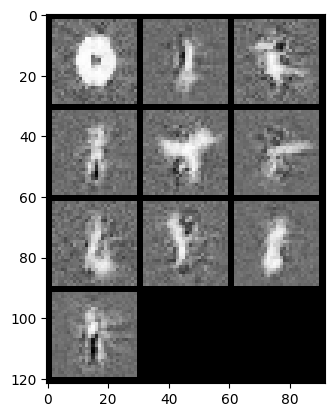

epoch: 321 g_loss: 10.337308883666992 d_loss: 0.000915801307807366
epoch: 322 g_loss: 10.675138473510742 d_loss: 0.002538802412648996
epoch: 323 g_loss: 11.207074165344238 d_loss: 0.01923234884937604
epoch: 324 g_loss: 8.680221557617188 d_loss: 0.006363057220975558
epoch: 325 g_loss: 9.511286735534668 d_loss: 0.0007683695293962955
epoch: 326 g_loss: 10.181114196777344 d_loss: 0.004624176460007827
epoch: 327 g_loss: 11.273828506469727 d_loss: 0.0004178793169558048
epoch: 328 g_loss: 8.613664627075195 d_loss: 0.003793800870577494
epoch: 329 g_loss: 8.932437896728516 d_loss: 0.001389379147440195
epoch: 330 g_loss: 10.550310134887695 d_loss: 0.01490572839975357
epoch: 331 g_loss: 10.597193717956543 d_loss: 0.011817981799443563
epoch: 332 g_loss: 10.12531566619873 d_loss: 0.0031280809392531714
epoch: 333 g_loss: 9.212059020996094 d_loss: 0.005497978379329045
epoch: 334 g_loss: 9.772927284240723 d_loss: 0.00106779873992006
epoch: 335 g_loss: 10.446561813354492 d_loss: 0.0012217373587191105
e

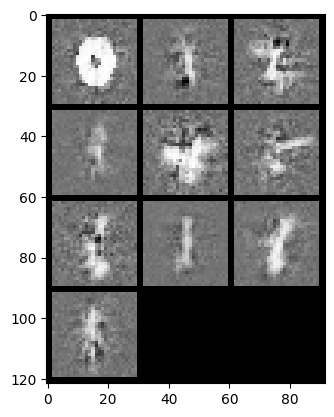

epoch: 341 g_loss: 11.400190353393555 d_loss: 0.005945191408197085
epoch: 342 g_loss: 8.744315147399902 d_loss: 0.0013486739868919055
epoch: 343 g_loss: 9.645758628845215 d_loss: 0.0016406187787652016
epoch: 344 g_loss: 9.065361022949219 d_loss: 0.0006751262117177248
epoch: 345 g_loss: 9.616436004638672 d_loss: 0.0037232606361309686
epoch: 346 g_loss: 8.782297134399414 d_loss: 0.003929666864375274
epoch: 347 g_loss: 10.797889709472656 d_loss: 0.0013936318767567475
epoch: 348 g_loss: 10.935824394226074 d_loss: 0.001974816589305798
epoch: 349 g_loss: 10.669147491455078 d_loss: 0.0033267984787623086
epoch: 350 g_loss: 12.499361991882324 d_loss: 0.01049122711022695
epoch: 351 g_loss: 12.203468322753906 d_loss: 0.0010023957584053278
epoch: 352 g_loss: 8.912467956542969 d_loss: 0.008973850558201471
epoch: 353 g_loss: 11.90249252319336 d_loss: 0.0001915796116615335
epoch: 354 g_loss: 11.847384452819824 d_loss: 0.010189486667513847
epoch: 355 g_loss: 12.205923080444336 d_loss: 0.00733296448985

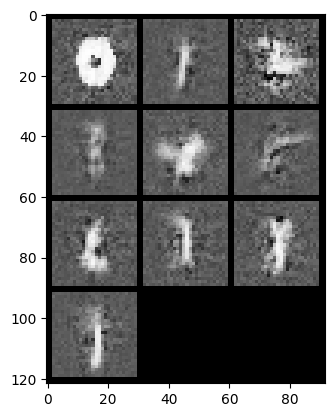

epoch: 361 g_loss: 10.710299491882324 d_loss: 0.005155579186975956
epoch: 362 g_loss: 10.01154613494873 d_loss: 0.0006856932304799557
epoch: 363 g_loss: 11.671462059020996 d_loss: 0.0003026676131412387
epoch: 364 g_loss: 9.474679946899414 d_loss: 0.0010486531537026167
epoch: 365 g_loss: 10.280427932739258 d_loss: 0.006311244020859401
epoch: 366 g_loss: 9.398276329040527 d_loss: 0.0006658865604549646
epoch: 367 g_loss: 10.343450546264648 d_loss: 0.004298504441976547
epoch: 368 g_loss: 10.124677658081055 d_loss: 0.0029467310135563216
epoch: 369 g_loss: 10.06987476348877 d_loss: 0.00673297606408596
epoch: 370 g_loss: 9.788594245910645 d_loss: 0.00257787915567557
epoch: 371 g_loss: 9.956951141357422 d_loss: 0.0063127875328063965
epoch: 372 g_loss: 10.215682983398438 d_loss: 0.001081562756250302
epoch: 373 g_loss: 9.951629638671875 d_loss: 0.001325662403057019
epoch: 374 g_loss: 12.429009437561035 d_loss: 0.0019488992790381114
epoch: 375 g_loss: 13.396617889404297 d_loss: 0.0026966799050569

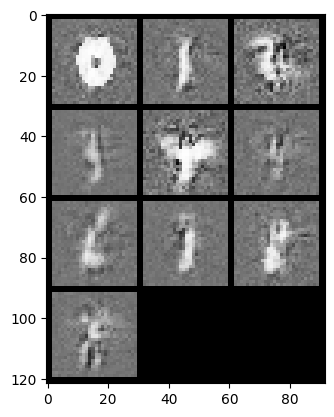

epoch: 381 g_loss: 10.160984992980957 d_loss: 0.0170561745762825
epoch: 382 g_loss: 9.998489379882812 d_loss: 0.027917300661404926
epoch: 383 g_loss: 10.770828247070312 d_loss: 0.0022096334335704646
epoch: 384 g_loss: 9.968095779418945 d_loss: 0.017883941531181335
epoch: 385 g_loss: 9.761974334716797 d_loss: 0.019454178710778553
epoch: 386 g_loss: 11.928929328918457 d_loss: 0.0021358135466774306
epoch: 387 g_loss: 10.391788482666016 d_loss: 0.0013120054888228576
epoch: 388 g_loss: 10.2266263961792 d_loss: 0.01747148483991623
epoch: 389 g_loss: 10.154251098632812 d_loss: 0.01222513864437739
epoch: 390 g_loss: 10.836408615112305 d_loss: 0.000739111565053463
epoch: 391 g_loss: 9.14614486694336 d_loss: 0.006768616537253062
epoch: 392 g_loss: 8.738781929016113 d_loss: 0.014368971188863119
epoch: 393 g_loss: 9.504197120666504 d_loss: 0.0030811034763852754
epoch: 394 g_loss: 10.968889236450195 d_loss: 0.00040379570176204044
epoch: 395 g_loss: 10.666539192199707 d_loss: 0.02064405381679535
epo

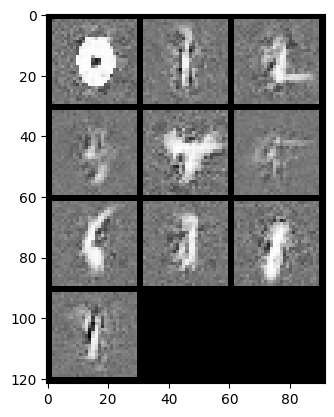

epoch: 401 g_loss: 9.632465362548828 d_loss: 0.0006119804068778952
epoch: 402 g_loss: 12.00954818725586 d_loss: 0.0007678327771524588
epoch: 403 g_loss: 10.543489456176758 d_loss: 0.01773783192038536
epoch: 404 g_loss: 10.137569427490234 d_loss: 0.0028494844834009805
epoch: 405 g_loss: 9.027969360351562 d_loss: 0.00571482814848423
epoch: 406 g_loss: 8.764684677124023 d_loss: 0.0014530269739528496
epoch: 407 g_loss: 8.176372528076172 d_loss: 0.010479122400283813
epoch: 408 g_loss: 8.880204200744629 d_loss: 0.00852811336517334
epoch: 409 g_loss: 8.615350723266602 d_loss: 0.010640432437260946
epoch: 410 g_loss: 10.457709312438965 d_loss: 0.0077859945595264435
epoch: 411 g_loss: 9.236502647399902 d_loss: 0.0021781775479515395
epoch: 412 g_loss: 8.820903778076172 d_loss: 0.004335904493927956
epoch: 413 g_loss: 11.22100830078125 d_loss: 0.002327496651560068
epoch: 414 g_loss: 10.021859169006348 d_loss: 0.011999196062485376
epoch: 415 g_loss: 9.298391342163086 d_loss: 0.008722588419914246
epo

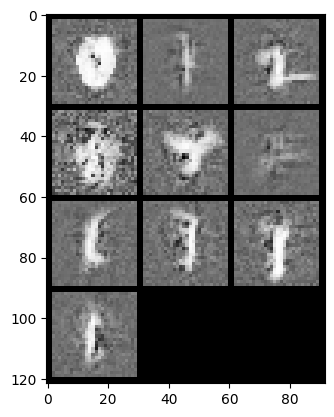

epoch: 421 g_loss: 13.033767700195312 d_loss: 0.0022114066717525325
epoch: 422 g_loss: 11.635915756225586 d_loss: 0.0037206818039218583
epoch: 423 g_loss: 12.413280487060547 d_loss: 0.0008988562040030956
epoch: 424 g_loss: 9.957962036132812 d_loss: 0.0015661014864842098
epoch: 425 g_loss: 12.732267379760742 d_loss: 0.001408409948150317
epoch: 426 g_loss: 11.646896362304688 d_loss: 0.0019422303885221481
epoch: 427 g_loss: 12.415931701660156 d_loss: 0.005397857477267583
epoch: 428 g_loss: 11.982542037963867 d_loss: 0.00357117069264253
epoch: 429 g_loss: 11.783496856689453 d_loss: 0.0129367063442866
epoch: 430 g_loss: 10.403507232666016 d_loss: 0.012185368686914444
epoch: 431 g_loss: 11.422493934631348 d_loss: 0.0009441017949332794
epoch: 432 g_loss: 11.912385940551758 d_loss: 0.011014722287654877
epoch: 433 g_loss: 15.024168014526367 d_loss: 0.0008412672517200311
epoch: 434 g_loss: 10.529257774353027 d_loss: 0.0009586348508795103
epoch: 435 g_loss: 11.958236694335938 d_loss: 0.0039869882

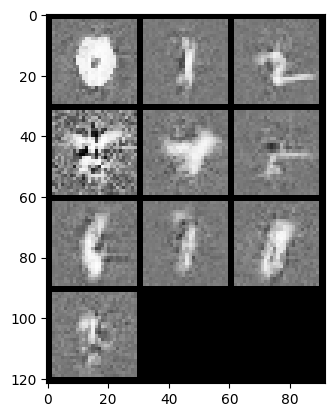

epoch: 441 g_loss: 8.72027587890625 d_loss: 0.002198337111622095
epoch: 442 g_loss: 9.368054389953613 d_loss: 0.022134860356648762
epoch: 443 g_loss: 11.206438064575195 d_loss: 0.004819941396514575
epoch: 444 g_loss: 9.347066879272461 d_loss: 0.005049678807457288
epoch: 445 g_loss: 9.415821075439453 d_loss: 0.0006589153005431095
epoch: 446 g_loss: 9.213390350341797 d_loss: 0.0010533657235403855
epoch: 447 g_loss: 9.856196403503418 d_loss: 0.002550799554834763
epoch: 448 g_loss: 10.38396167755127 d_loss: 0.0003944904310628772
epoch: 449 g_loss: 10.166120529174805 d_loss: 0.012128772834936777
epoch: 450 g_loss: 10.275984764099121 d_loss: 0.0005560412537306547
epoch: 451 g_loss: 10.216389656066895 d_loss: 0.0030890613173445067
epoch: 452 g_loss: 12.33765983581543 d_loss: 0.02667047828435898
epoch: 453 g_loss: 11.412491798400879 d_loss: 0.005179586509863536
epoch: 454 g_loss: 9.560523986816406 d_loss: 0.005205385076502959
epoch: 455 g_loss: 10.441561698913574 d_loss: 0.0022487095557153225


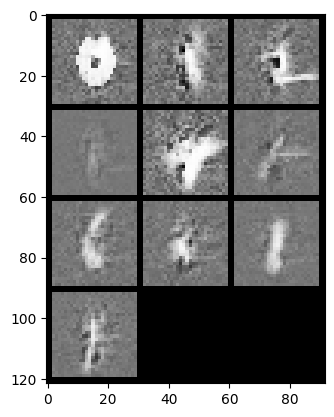

epoch: 461 g_loss: 8.563433647155762 d_loss: 0.005129659548401833
epoch: 462 g_loss: 10.296493530273438 d_loss: 0.004146714694797993
epoch: 463 g_loss: 10.466949462890625 d_loss: 0.0008770723361521959
epoch: 464 g_loss: 10.88578987121582 d_loss: 0.010401289910078049
epoch: 465 g_loss: 9.716012954711914 d_loss: 0.002260918729007244
epoch: 466 g_loss: 8.88880729675293 d_loss: 0.0013342173770070076
epoch: 467 g_loss: 9.894644737243652 d_loss: 0.0005690641313170394
epoch: 468 g_loss: 8.853443145751953 d_loss: 0.013749332477649054
epoch: 469 g_loss: 8.80398941040039 d_loss: 0.0012959213927388191
epoch: 470 g_loss: 9.182771682739258 d_loss: 0.00073263980448246
epoch: 471 g_loss: 11.420843124389648 d_loss: 0.00012873419715712467
epoch: 472 g_loss: 7.727577209472656 d_loss: 0.003697792378564676
epoch: 473 g_loss: 10.77625846862793 d_loss: 0.00012128854480882485
epoch: 474 g_loss: 10.637779235839844 d_loss: 0.002999126290281614
epoch: 475 g_loss: 8.748664855957031 d_loss: 0.0012708089003960292


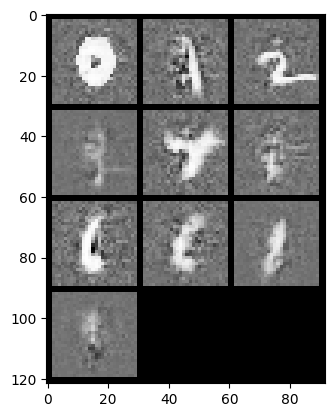

epoch: 481 g_loss: 10.388324737548828 d_loss: 0.022895673910776775
epoch: 482 g_loss: 10.005581855773926 d_loss: 0.003693616638580958
epoch: 483 g_loss: 9.438957214355469 d_loss: 0.0022727539762854576
epoch: 484 g_loss: 8.808368682861328 d_loss: 0.0016240513262649376
epoch: 485 g_loss: 10.690424919128418 d_loss: 0.00043657647135357064
epoch: 486 g_loss: 9.773642539978027 d_loss: 0.005861769740780194
epoch: 487 g_loss: 10.064870834350586 d_loss: 0.0013263692768911521
epoch: 488 g_loss: 8.844929695129395 d_loss: 0.0011573984908560913
epoch: 489 g_loss: 8.665886878967285 d_loss: 0.009155592570702234
epoch: 490 g_loss: 9.897957801818848 d_loss: 0.0008075908602525791
epoch: 491 g_loss: 9.154146194458008 d_loss: 0.021726200977961223
epoch: 492 g_loss: 9.331215858459473 d_loss: 0.009801199659705162
epoch: 493 g_loss: 11.720053672790527 d_loss: 0.0007346378018458685
epoch: 494 g_loss: 11.848864555358887 d_loss: 0.0022602050254742303
epoch: 495 g_loss: 9.824299812316895 d_loss: 0.00362853581706

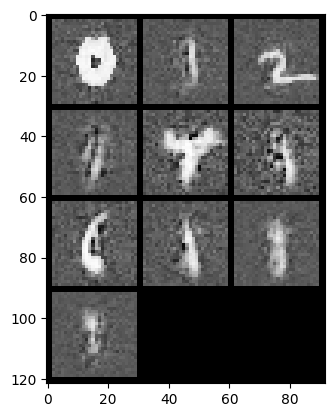

epoch: 501 g_loss: 9.922357559204102 d_loss: 0.0005536783719435334
epoch: 502 g_loss: 11.289512634277344 d_loss: 0.0038027850290139518
epoch: 503 g_loss: 8.874329566955566 d_loss: 0.002496731001883745
epoch: 504 g_loss: 7.852646350860596 d_loss: 0.016149849941333134
epoch: 505 g_loss: 9.237447738647461 d_loss: 0.0030657549699147544
epoch: 506 g_loss: 9.668001174926758 d_loss: 0.009155597537755966
epoch: 507 g_loss: 9.181435585021973 d_loss: 0.0013388094181815784
epoch: 508 g_loss: 10.323720932006836 d_loss: 0.0005189696870123347
epoch: 509 g_loss: 9.027338027954102 d_loss: 0.0016264830095072587
epoch: 510 g_loss: 9.164451599121094 d_loss: 0.00029601026714469
epoch: 511 g_loss: 8.510211944580078 d_loss: 0.011797012140353521
epoch: 512 g_loss: 9.474845886230469 d_loss: 0.0020333401237924895
epoch: 513 g_loss: 9.79092788696289 d_loss: 0.0007455543770144383
epoch: 514 g_loss: 10.138408660888672 d_loss: 0.0018746362378199895
epoch: 515 g_loss: 11.002071380615234 d_loss: 0.006202199185887973

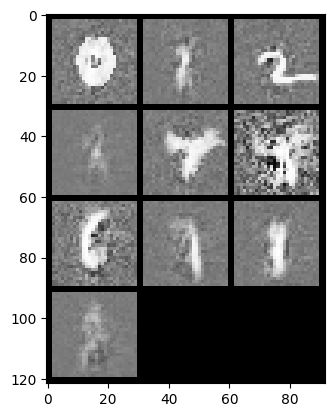

epoch: 521 g_loss: 12.454609870910645 d_loss: 0.006887134164571762
epoch: 522 g_loss: 10.720640182495117 d_loss: 0.002991719792286555
epoch: 523 g_loss: 12.866042137145996 d_loss: 0.0008660410530865192
epoch: 524 g_loss: 12.406474113464355 d_loss: 0.0012295423075556755
epoch: 525 g_loss: 10.07813549041748 d_loss: 0.0017674945605297883
epoch: 526 g_loss: 11.28478717803955 d_loss: 0.002704078331589699
epoch: 527 g_loss: 10.995208740234375 d_loss: 0.0008191319648176432
epoch: 528 g_loss: 11.628215789794922 d_loss: 0.00042087371305872995
epoch: 529 g_loss: 10.03491497039795 d_loss: 0.007801687344908714
epoch: 530 g_loss: 11.181899070739746 d_loss: 0.006406507144371669
epoch: 531 g_loss: 10.120604515075684 d_loss: 0.001544914674013853
epoch: 532 g_loss: 11.055418968200684 d_loss: 0.005522799367705981
epoch: 533 g_loss: 9.972705841064453 d_loss: 0.007708934446175893
epoch: 534 g_loss: 8.857487678527832 d_loss: 0.0016976590268313885
epoch: 535 g_loss: 9.114346504211426 d_loss: 0.0102619733661

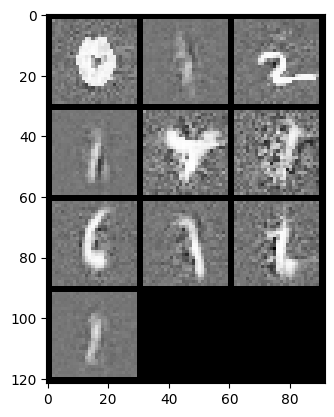

epoch: 541 g_loss: 11.425874710083008 d_loss: 0.0036153861631949744
epoch: 542 g_loss: 9.006988525390625 d_loss: 0.0021276564026872316
epoch: 543 g_loss: 9.269972801208496 d_loss: 0.0008026757277548313
epoch: 544 g_loss: 9.510553359985352 d_loss: 0.006807465106248856
epoch: 545 g_loss: 8.213099479675293 d_loss: 0.0015489176536599796
epoch: 546 g_loss: 10.227510452270508 d_loss: 0.00670895849665006
epoch: 547 g_loss: 10.623178482055664 d_loss: 0.004558654812475045
epoch: 548 g_loss: 9.330989837646484 d_loss: 0.0035933122659722963
epoch: 549 g_loss: 11.693085670471191 d_loss: 0.0016246285910407703
epoch: 550 g_loss: 11.47785472869873 d_loss: 0.013664480298757553
epoch: 551 g_loss: 9.076010704040527 d_loss: 0.0013469493327041466
epoch: 552 g_loss: 9.525479316711426 d_loss: 0.01073728377620379
epoch: 553 g_loss: 9.652708053588867 d_loss: 0.0007175491967548927
epoch: 554 g_loss: 9.257564544677734 d_loss: 0.0006883765260378519
epoch: 555 g_loss: 9.41081714630127 d_loss: 0.011167418211698532


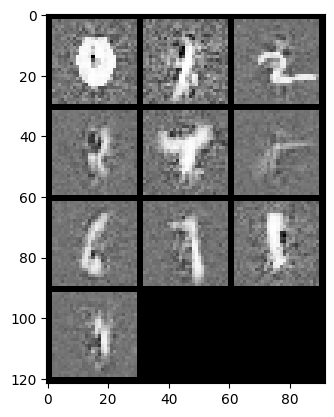

epoch: 561 g_loss: 9.403250694274902 d_loss: 0.003168337047100067
epoch: 562 g_loss: 8.903807640075684 d_loss: 0.0029526231810450554
epoch: 563 g_loss: 10.852605819702148 d_loss: 0.0019808486104011536
epoch: 564 g_loss: 11.12066650390625 d_loss: 0.0006540592294186354
epoch: 565 g_loss: 10.434051513671875 d_loss: 0.0005493406982471546
epoch: 566 g_loss: 12.515256881713867 d_loss: 0.0015861100206772487
epoch: 567 g_loss: 10.25485897064209 d_loss: 0.002305234937618176
epoch: 568 g_loss: 11.122404098510742 d_loss: 0.00387475515405337
epoch: 569 g_loss: 13.137260437011719 d_loss: 0.0004192232930411895
epoch: 570 g_loss: 10.477949142456055 d_loss: 0.004115874568621318
epoch: 571 g_loss: 11.326833724975586 d_loss: 0.0038448249300320945
epoch: 572 g_loss: 10.9827299118042 d_loss: 0.013113302489121756
epoch: 573 g_loss: 9.106788635253906 d_loss: 0.0004313694468388955
epoch: 574 g_loss: 8.814258575439453 d_loss: 0.00082602941741546
epoch: 575 g_loss: 9.815702438354492 d_loss: 0.00615810851256052

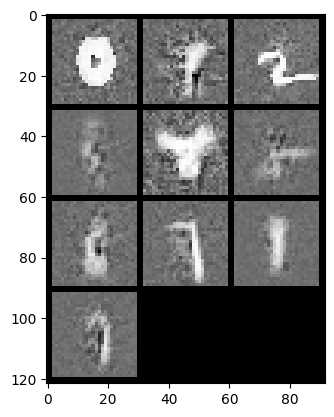

epoch: 581 g_loss: 12.146547317504883 d_loss: 0.012844979763031006
epoch: 582 g_loss: 9.887561798095703 d_loss: 0.011543280134598414
epoch: 583 g_loss: 8.68313217163086 d_loss: 0.0011883511518438656
epoch: 584 g_loss: 9.313433647155762 d_loss: 0.015351403504610062
epoch: 585 g_loss: 8.749457359313965 d_loss: 0.002039068378508091
epoch: 586 g_loss: 8.62244987487793 d_loss: 0.0016043903306126595
epoch: 587 g_loss: 10.778656959533691 d_loss: 0.002420989175637563
epoch: 588 g_loss: 10.394597053527832 d_loss: 0.017498592535654705
epoch: 589 g_loss: 7.707918167114258 d_loss: 0.002471589638541142
epoch: 590 g_loss: 7.726818561553955 d_loss: 0.010488317658503851
epoch: 591 g_loss: 12.935770034790039 d_loss: 0.013389793535073599
epoch: 592 g_loss: 10.402400016784668 d_loss: 0.0002947684843093157
epoch: 593 g_loss: 7.716989040374756 d_loss: 0.001485836071272691
epoch: 594 g_loss: 9.371562004089355 d_loss: 0.01082167774438858
epoch: 595 g_loss: 8.450823783874512 d_loss: 0.008393087113897005
epoch

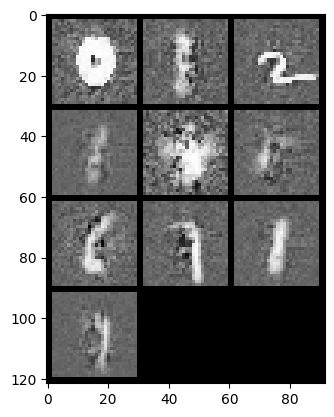

epoch: 601 g_loss: 8.43934440612793 d_loss: 0.008824352795879046
epoch: 602 g_loss: 8.822125434875488 d_loss: 0.0012342908109227817
epoch: 603 g_loss: 9.56538200378418 d_loss: 0.0003821303059036533
epoch: 604 g_loss: 8.651844024658203 d_loss: 0.035091668367385864
epoch: 605 g_loss: 9.70329475402832 d_loss: 0.0028438915808995566
epoch: 606 g_loss: 8.933032989501953 d_loss: 0.016179895649353664
epoch: 607 g_loss: 7.958555698394775 d_loss: 0.017711102962493896
epoch: 608 g_loss: 7.75054931640625 d_loss: 0.005373636881510417
epoch: 609 g_loss: 8.767934799194336 d_loss: 0.018626373261213303
epoch: 610 g_loss: 10.712869644165039 d_loss: 0.005051379092037678
epoch: 611 g_loss: 9.910687446594238 d_loss: 0.005901566396156947
epoch: 612 g_loss: 8.989274024963379 d_loss: 0.0028450104097525277
epoch: 613 g_loss: 8.451371192932129 d_loss: 0.0015471959486603737
epoch: 614 g_loss: 8.91964340209961 d_loss: 0.018473530809084576
epoch: 615 g_loss: 10.007378578186035 d_loss: 0.0019435763048628967
epoch: 

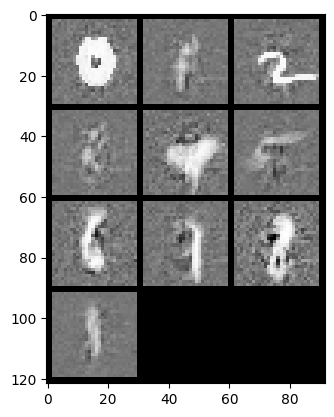

epoch: 621 g_loss: 8.457155227661133 d_loss: 0.006717630351583163
epoch: 622 g_loss: 8.835310935974121 d_loss: 0.0012555270610998075
epoch: 623 g_loss: 8.870515823364258 d_loss: 0.00694273163874944
epoch: 624 g_loss: 9.4044771194458 d_loss: 0.0012654511568446953
epoch: 625 g_loss: 9.35599422454834 d_loss: 0.0014328239485621452
epoch: 626 g_loss: 9.99942398071289 d_loss: 0.010436572134494781
epoch: 627 g_loss: 10.794698715209961 d_loss: 0.01352305089433988
epoch: 628 g_loss: 9.923382759094238 d_loss: 0.0017276063250998657
epoch: 629 g_loss: 9.505663871765137 d_loss: 0.005823730180660884
epoch: 630 g_loss: 8.340337753295898 d_loss: 0.017872435351212818
epoch: 631 g_loss: 9.911157608032227 d_loss: 0.00018659525085240602
epoch: 632 g_loss: 8.725893020629883 d_loss: 0.012936572233835856
epoch: 633 g_loss: 9.517210006713867 d_loss: 0.001697034730265538
epoch: 634 g_loss: 8.553050994873047 d_loss: 0.0014240415766835213
epoch: 635 g_loss: 10.547849655151367 d_loss: 0.0001486798282712698
epoch:

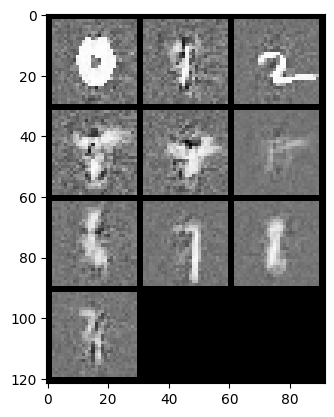

epoch: 641 g_loss: 10.153995513916016 d_loss: 0.009033586209019026
epoch: 642 g_loss: 11.743253707885742 d_loss: 8.891158116360505e-05
epoch: 643 g_loss: 9.306517601013184 d_loss: 0.0019546994008123875
epoch: 644 g_loss: 8.813240051269531 d_loss: 0.0002981290260019402
epoch: 645 g_loss: 8.431090354919434 d_loss: 0.0015351870097219944
epoch: 646 g_loss: 9.074117660522461 d_loss: 0.0016787643544375896
epoch: 647 g_loss: 10.025758743286133 d_loss: 0.0016169870893160503
epoch: 648 g_loss: 10.312835693359375 d_loss: 0.0018335478380322456
epoch: 649 g_loss: 10.278579711914062 d_loss: 0.0009242692807068428
epoch: 650 g_loss: 9.210777282714844 d_loss: 0.009197120865186056
epoch: 651 g_loss: 10.277536392211914 d_loss: 0.00023469470518951616
epoch: 652 g_loss: 8.86476993560791 d_loss: 0.0035209457079569497
epoch: 653 g_loss: 10.479318618774414 d_loss: 0.0003808964587127169
epoch: 654 g_loss: 9.995845794677734 d_loss: 0.00014047729200683534
epoch: 655 g_loss: 11.0372314453125 d_loss: 0.0011445084

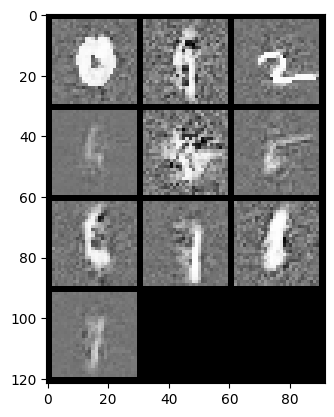

epoch: 661 g_loss: 10.328591346740723 d_loss: 0.00016733352094888687
epoch: 662 g_loss: 8.81342887878418 d_loss: 0.0015528717388709385
epoch: 663 g_loss: 9.381438255310059 d_loss: 0.000986662848542134
epoch: 664 g_loss: 11.93983268737793 d_loss: 0.0001642744173295796
epoch: 665 g_loss: 10.892777442932129 d_loss: 0.0032290763532121978
epoch: 666 g_loss: 11.722382545471191 d_loss: 0.005731197074055672
epoch: 667 g_loss: 10.389444351196289 d_loss: 0.00026079521436865133
epoch: 668 g_loss: 10.816349029541016 d_loss: 0.00014355996002753577
epoch: 669 g_loss: 10.851272583007812 d_loss: 0.00417966643969218
epoch: 670 g_loss: 9.036495208740234 d_loss: 0.00146820613493522
epoch: 671 g_loss: 9.398290634155273 d_loss: 0.006957027440269788
epoch: 672 g_loss: 9.19033432006836 d_loss: 0.0003696021546299259
epoch: 673 g_loss: 8.698920249938965 d_loss: 0.004354316120346387
epoch: 674 g_loss: 10.935023307800293 d_loss: 0.0010438491590321064
epoch: 675 g_loss: 9.256505966186523 d_loss: 0.006287983929117

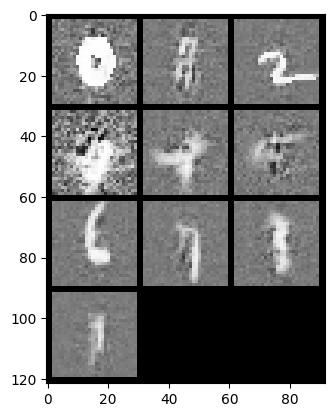

epoch: 681 g_loss: 12.0635347366333 d_loss: 0.013133099923531214
epoch: 682 g_loss: 9.746087074279785 d_loss: 0.0011524553410708904
epoch: 683 g_loss: 7.587644577026367 d_loss: 0.0038209169482191405
epoch: 684 g_loss: 11.319894790649414 d_loss: 0.00233812148993214
epoch: 685 g_loss: 9.6954345703125 d_loss: 0.0006702846537033716
epoch: 686 g_loss: 12.521455764770508 d_loss: 0.010911612461010614
epoch: 687 g_loss: 9.25562858581543 d_loss: 0.005918875336647034
epoch: 688 g_loss: 10.655130386352539 d_loss: 0.0018789383272329967
epoch: 689 g_loss: 8.909815788269043 d_loss: 0.006194174910585086
epoch: 690 g_loss: 10.394950866699219 d_loss: 0.0008218105261524519
epoch: 691 g_loss: 13.257219314575195 d_loss: 0.0036442636822660766
epoch: 692 g_loss: 9.691191673278809 d_loss: 0.00031780694068099063
epoch: 693 g_loss: 10.360041618347168 d_loss: 0.0008359731485446295
epoch: 694 g_loss: 9.260461807250977 d_loss: 0.0011527870471278827
epoch: 695 g_loss: 9.871248245239258 d_loss: 0.001254731866841514

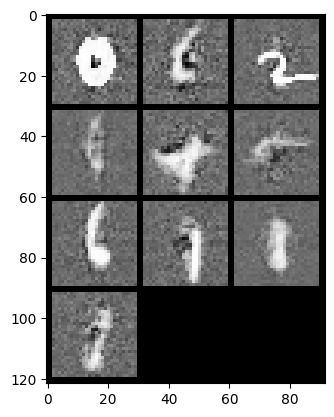

epoch: 701 g_loss: 10.085113525390625 d_loss: 0.008794210851192474
epoch: 702 g_loss: 8.04808235168457 d_loss: 0.02711653212706248
epoch: 703 g_loss: 7.617494106292725 d_loss: 0.01526587704817454
epoch: 704 g_loss: 8.463536262512207 d_loss: 0.0015041905765732129
epoch: 705 g_loss: 9.683964729309082 d_loss: 0.000720893886561195
epoch: 706 g_loss: 9.38375473022461 d_loss: 0.0003818170710777243
epoch: 707 g_loss: 8.699424743652344 d_loss: 0.01923901339371999
epoch: 708 g_loss: 8.301589965820312 d_loss: 0.0025180595306058726
epoch: 709 g_loss: 9.3826265335083 d_loss: 0.009448964148759842
epoch: 710 g_loss: 7.9843854904174805 d_loss: 0.0035828702772657075
epoch: 711 g_loss: 8.1697359085083 d_loss: 0.0019404408521950245
epoch: 712 g_loss: 9.653465270996094 d_loss: 0.00018114899285137653
epoch: 713 g_loss: 8.314388275146484 d_loss: 0.0007148777755598227
epoch: 714 g_loss: 9.95409107208252 d_loss: 0.005982656652728717
epoch: 715 g_loss: 11.566498756408691 d_loss: 0.0033936332911252975
epoch: 7

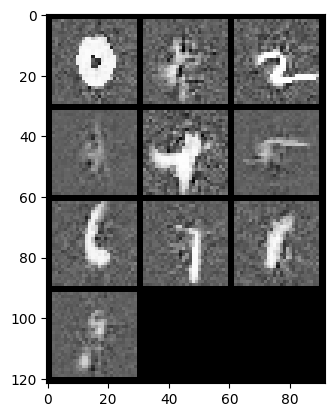

epoch: 721 g_loss: 9.361441612243652 d_loss: 0.0005028000644718608
epoch: 722 g_loss: 8.085702896118164 d_loss: 0.0007970809626082579
epoch: 723 g_loss: 8.901771545410156 d_loss: 0.0033590573196609816
epoch: 724 g_loss: 8.5485258102417 d_loss: 0.0007113988200823466
epoch: 725 g_loss: 11.501294136047363 d_loss: 0.022337019443511963
epoch: 726 g_loss: 9.21895694732666 d_loss: 0.00015631608160523078
epoch: 727 g_loss: 10.02320384979248 d_loss: 0.00030444853473454714
epoch: 728 g_loss: 9.208078384399414 d_loss: 0.0007948492032786211
epoch: 729 g_loss: 9.876276016235352 d_loss: 0.0004412742176403602
epoch: 730 g_loss: 9.468801498413086 d_loss: 0.0008396886599560579
epoch: 731 g_loss: 9.36105728149414 d_loss: 0.0002200623469737669
epoch: 732 g_loss: 8.768837928771973 d_loss: 0.0020039298882087073
epoch: 733 g_loss: 8.623479843139648 d_loss: 0.01758466785152753
epoch: 734 g_loss: 9.63515567779541 d_loss: 0.0006881869242837032
epoch: 735 g_loss: 9.914124488830566 d_loss: 0.001400076939413945
e

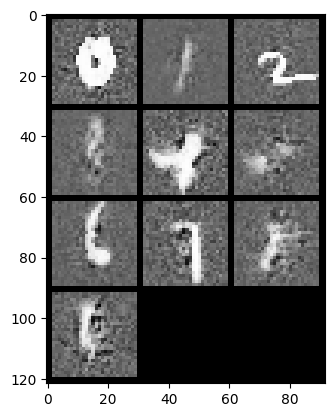

epoch: 741 g_loss: 7.688909530639648 d_loss: 0.0009981185818711917
epoch: 742 g_loss: 8.792020797729492 d_loss: 0.0009846569349368413
epoch: 743 g_loss: 8.090675354003906 d_loss: 0.020152452091375988
epoch: 744 g_loss: 11.434503555297852 d_loss: 0.0054043543835481005
epoch: 745 g_loss: 8.53898811340332 d_loss: 0.0016732752944032352
epoch: 746 g_loss: 9.438668251037598 d_loss: 0.003624342381954193
epoch: 747 g_loss: 9.564539909362793 d_loss: 0.000444103148765862
epoch: 748 g_loss: 10.358419418334961 d_loss: 0.0004308257872859637
epoch: 749 g_loss: 9.256048202514648 d_loss: 0.0027525480836629868
epoch: 750 g_loss: 9.880555152893066 d_loss: 0.00665651448071003
epoch: 751 g_loss: 9.217364311218262 d_loss: 0.006952398767073949
epoch: 752 g_loss: 10.080206871032715 d_loss: 0.001174076460301876
epoch: 753 g_loss: 10.75971794128418 d_loss: 0.0012341838640471299
epoch: 754 g_loss: 9.543787956237793 d_loss: 0.0004503582992280523
epoch: 755 g_loss: 10.098468780517578 d_loss: 0.0006181305119146904

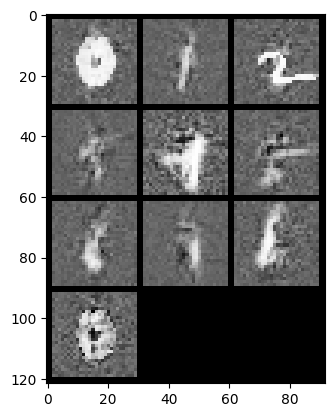

epoch: 761 g_loss: 10.04514217376709 d_loss: 0.0003835581398258607
epoch: 762 g_loss: 10.05777359008789 d_loss: 0.031876884400844574
epoch: 763 g_loss: 9.842050552368164 d_loss: 0.000680360555027922
epoch: 764 g_loss: 7.793821334838867 d_loss: 0.012682653963565826
epoch: 765 g_loss: 10.843626976013184 d_loss: 0.0035830202202002206
epoch: 766 g_loss: 10.941490173339844 d_loss: 0.004180993263920148
epoch: 767 g_loss: 10.572259902954102 d_loss: 0.0007603364065289497
epoch: 768 g_loss: 9.070362091064453 d_loss: 0.0006001561026399335
epoch: 769 g_loss: 10.842535018920898 d_loss: 0.005784100542465846
epoch: 770 g_loss: 9.520600318908691 d_loss: 0.0013947941673298676
epoch: 771 g_loss: 9.081859588623047 d_loss: 0.001202034919212262
epoch: 772 g_loss: 10.04977798461914 d_loss: 0.0012326506742586691
epoch: 773 g_loss: 9.485151290893555 d_loss: 0.016442179679870605
epoch: 774 g_loss: 11.657079696655273 d_loss: 0.000598172734801968
epoch: 775 g_loss: 10.265264511108398 d_loss: 0.00619146041572094

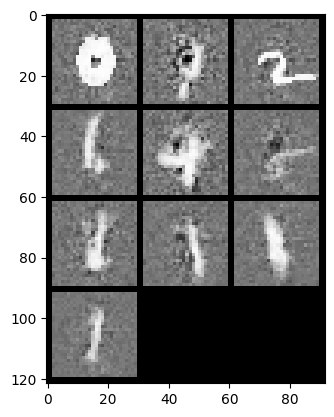

epoch: 781 g_loss: 9.252218246459961 d_loss: 0.0008841634262353182
epoch: 782 g_loss: 9.570845603942871 d_loss: 0.0005878912440190712
epoch: 783 g_loss: 8.171801567077637 d_loss: 0.006615111604332924
epoch: 784 g_loss: 8.090092658996582 d_loss: 0.0007353008259087801
epoch: 785 g_loss: 9.413846969604492 d_loss: 0.006794440870483716
epoch: 786 g_loss: 9.05587387084961 d_loss: 0.00042567770772924024
epoch: 787 g_loss: 8.902642250061035 d_loss: 0.0060848041127125425
epoch: 788 g_loss: 10.840657234191895 d_loss: 0.0008869204514970382
epoch: 789 g_loss: 9.646199226379395 d_loss: 0.0014057632846136887
epoch: 790 g_loss: 10.073878288269043 d_loss: 0.01535720999042193
epoch: 791 g_loss: 9.343559265136719 d_loss: 0.0006625907650838295
epoch: 792 g_loss: 10.517980575561523 d_loss: 0.00014491092103223005
epoch: 793 g_loss: 9.661432266235352 d_loss: 0.003025377169251442
epoch: 794 g_loss: 9.571703910827637 d_loss: 0.0003222524149653812
epoch: 795 g_loss: 8.406761169433594 d_loss: 0.0139835377534230

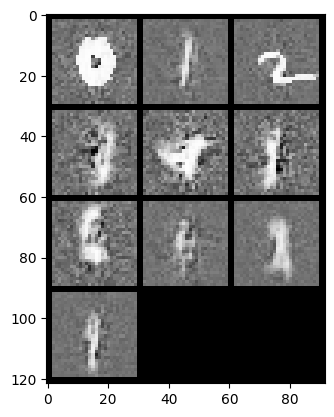

epoch: 801 g_loss: 9.63571548461914 d_loss: 0.0009605673452218374
epoch: 802 g_loss: 8.753519058227539 d_loss: 0.0024434123188257217
epoch: 803 g_loss: 11.504918098449707 d_loss: 0.00012434821110218763
epoch: 804 g_loss: 9.040018081665039 d_loss: 0.000652447265262405
epoch: 805 g_loss: 9.686264038085938 d_loss: 0.05945362647374471
epoch: 806 g_loss: 8.807519912719727 d_loss: 0.0010473006404936314
epoch: 807 g_loss: 9.017635345458984 d_loss: 0.0016433352914949257
epoch: 808 g_loss: 9.131256103515625 d_loss: 0.004571488127112389
epoch: 809 g_loss: 11.33699893951416 d_loss: 0.0006732471908132235
epoch: 810 g_loss: 10.866548538208008 d_loss: 0.0016938395177324612
epoch: 811 g_loss: 14.292433738708496 d_loss: 0.0017386628314852715
epoch: 812 g_loss: 10.570064544677734 d_loss: 0.00048342479082445305
epoch: 813 g_loss: 11.634583473205566 d_loss: 0.0006576398542771736
epoch: 814 g_loss: 12.517436027526855 d_loss: 0.0004908977231631676
epoch: 815 g_loss: 9.763619422912598 d_loss: 0.001447834695

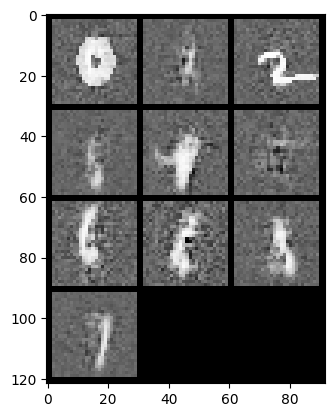

epoch: 821 g_loss: 9.204362869262695 d_loss: 0.0012377941360076268
epoch: 822 g_loss: 9.261634826660156 d_loss: 0.0012777529967327912
epoch: 823 g_loss: 9.387214660644531 d_loss: 0.002421997177104155
epoch: 824 g_loss: 10.343618392944336 d_loss: 0.0016960185021162033
epoch: 825 g_loss: 8.24085807800293 d_loss: 0.0028602018331487975
epoch: 826 g_loss: 8.287271499633789 d_loss: 0.0006252320405716697
epoch: 827 g_loss: 8.875389099121094 d_loss: 0.001359798324604829
epoch: 828 g_loss: 9.904037475585938 d_loss: 0.0061310455203056335
epoch: 829 g_loss: 10.806257247924805 d_loss: 0.001992127082000176
epoch: 830 g_loss: 9.799938201904297 d_loss: 0.001934847484032313
epoch: 831 g_loss: 9.470998764038086 d_loss: 0.0007553544516364733
epoch: 832 g_loss: 9.25407600402832 d_loss: 0.001542364712804556
epoch: 833 g_loss: 10.224681854248047 d_loss: 0.003336559981107712
epoch: 834 g_loss: 9.11577033996582 d_loss: 0.0014196412327388923
epoch: 835 g_loss: 8.759912490844727 d_loss: 0.0011068959720432758
e

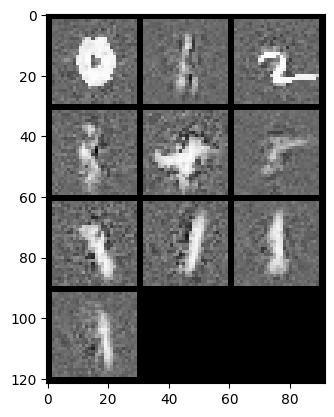

epoch: 841 g_loss: 9.636284828186035 d_loss: 0.009352818752328554
epoch: 842 g_loss: 9.029170036315918 d_loss: 0.001702129530409972
epoch: 843 g_loss: 8.852460861206055 d_loss: 0.0011087373519937198
epoch: 844 g_loss: 11.019464492797852 d_loss: 0.01622651269038518
epoch: 845 g_loss: 10.573450088500977 d_loss: 0.00016925681848078966
epoch: 846 g_loss: 9.543973922729492 d_loss: 0.0005922849134852489
epoch: 847 g_loss: 9.003175735473633 d_loss: 0.0025546535228689513
epoch: 848 g_loss: 9.463127136230469 d_loss: 0.03579688568909963
epoch: 849 g_loss: 11.179656982421875 d_loss: 0.000280918029602617
epoch: 850 g_loss: 8.321968078613281 d_loss: 0.009516394386688868
epoch: 851 g_loss: 11.308488845825195 d_loss: 0.007165006672342618
epoch: 852 g_loss: 11.2001371383667 d_loss: 0.01076106975475947
epoch: 853 g_loss: 9.073774337768555 d_loss: 0.022384966413180035
epoch: 854 g_loss: 10.160322189331055 d_loss: 0.005188714402417342
epoch: 855 g_loss: 9.727477073669434 d_loss: 0.009290770317117373
epoc

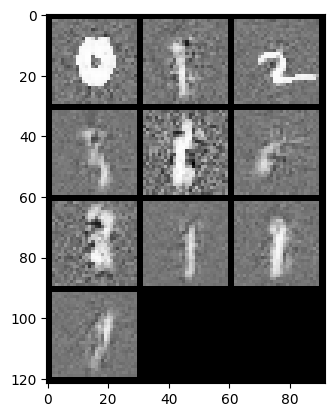

epoch: 861 g_loss: 13.102743148803711 d_loss: 0.003988041542470455
epoch: 862 g_loss: 8.621770858764648 d_loss: 0.0017052510132392247
epoch: 863 g_loss: 11.331859588623047 d_loss: 0.0024879959722359977
epoch: 864 g_loss: 10.840618133544922 d_loss: 0.0024311309680342674
epoch: 865 g_loss: 10.878384590148926 d_loss: 0.00014708403614349663
epoch: 866 g_loss: 10.88955020904541 d_loss: 0.005575534577171008
epoch: 867 g_loss: 9.036775588989258 d_loss: 0.00024022233750050267
epoch: 868 g_loss: 10.27739429473877 d_loss: 0.0006616983252267042
epoch: 869 g_loss: 11.647631645202637 d_loss: 0.005601592982808749
epoch: 870 g_loss: 10.74142837524414 d_loss: 0.000232148973736912
epoch: 871 g_loss: 9.20490837097168 d_loss: 0.01764475057522456
epoch: 872 g_loss: 10.082426071166992 d_loss: 0.0003739868989214301
epoch: 873 g_loss: 9.59412956237793 d_loss: 0.001980133509884278
epoch: 874 g_loss: 10.840179443359375 d_loss: 0.00018854780743519464
epoch: 875 g_loss: 10.650463104248047 d_loss: 0.0154871232807

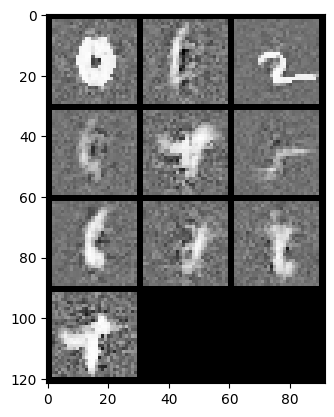

epoch: 881 g_loss: 11.715005874633789 d_loss: 0.00017199451879908642
epoch: 882 g_loss: 10.994975090026855 d_loss: 0.018275603652000427
epoch: 883 g_loss: 11.471365928649902 d_loss: 0.0002486421338592966
epoch: 884 g_loss: 10.382896423339844 d_loss: 0.0006154645622397462
epoch: 885 g_loss: 8.883002281188965 d_loss: 0.005177667054037253
epoch: 886 g_loss: 12.976091384887695 d_loss: 0.0005567441694438457
epoch: 887 g_loss: 12.175521850585938 d_loss: 0.0012910910105953615
epoch: 888 g_loss: 10.112276077270508 d_loss: 0.011515852063894272
epoch: 889 g_loss: 10.499343872070312 d_loss: 0.0010495850971589487
epoch: 890 g_loss: 10.499024391174316 d_loss: 0.005128299507002036
epoch: 891 g_loss: 11.043810844421387 d_loss: 0.0014204932376742363
epoch: 892 g_loss: 10.11234188079834 d_loss: 0.0013333635094265144
epoch: 893 g_loss: 10.332160949707031 d_loss: 0.000970067922025919
epoch: 894 g_loss: 10.505670547485352 d_loss: 0.0006593392075349888
epoch: 895 g_loss: 11.139629364013672 d_loss: 0.000664

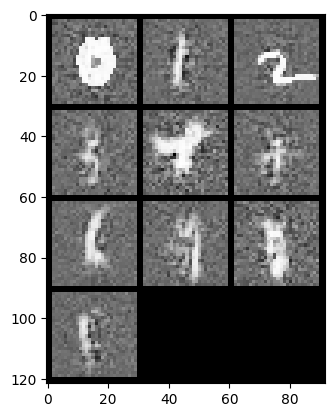

epoch: 901 g_loss: 10.884808540344238 d_loss: 0.0005629921409611901
epoch: 902 g_loss: 9.146966934204102 d_loss: 0.007326129823923111
epoch: 903 g_loss: 9.129876136779785 d_loss: 0.0012455487934251626
epoch: 904 g_loss: 9.531822204589844 d_loss: 0.001917093526571989
epoch: 905 g_loss: 8.867778778076172 d_loss: 0.0010609918584426243
epoch: 906 g_loss: 10.005888938903809 d_loss: 0.005524396275480588
epoch: 907 g_loss: 9.836048126220703 d_loss: 0.0004329512594267726
epoch: 908 g_loss: 9.90715503692627 d_loss: 0.002651181071996689
epoch: 909 g_loss: 10.749093055725098 d_loss: 0.0005108453333377838
epoch: 910 g_loss: 8.927937507629395 d_loss: 0.017306643227736156
epoch: 911 g_loss: 9.867328643798828 d_loss: 0.0007275429864724477
epoch: 912 g_loss: 10.222904205322266 d_loss: 0.00020197080448269844
epoch: 913 g_loss: 10.14271354675293 d_loss: 0.0026575708761811256
epoch: 914 g_loss: 9.683666229248047 d_loss: 0.003530796617269516
epoch: 915 g_loss: 11.00838851928711 d_loss: 0.00096508860588073

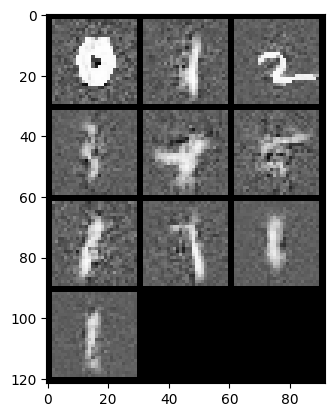

epoch: 921 g_loss: 8.593635559082031 d_loss: 0.0007300963625311852
epoch: 922 g_loss: 10.283862113952637 d_loss: 0.014822361369927725
epoch: 923 g_loss: 9.377344131469727 d_loss: 0.0029956120997667313
epoch: 924 g_loss: 9.7113676071167 d_loss: 0.019844654947519302
epoch: 925 g_loss: 7.834386825561523 d_loss: 0.005167690105736256
epoch: 926 g_loss: 9.740739822387695 d_loss: 0.00301324420919021
epoch: 927 g_loss: 9.391397476196289 d_loss: 0.0007059228761742512
epoch: 928 g_loss: 9.394142150878906 d_loss: 0.0007531025912612677
epoch: 929 g_loss: 10.338752746582031 d_loss: 0.01574474697311719
epoch: 930 g_loss: 9.442301750183105 d_loss: 0.0006735012866556644
epoch: 931 g_loss: 8.272047996520996 d_loss: 0.002522327316304048
epoch: 932 g_loss: 9.947244644165039 d_loss: 0.0008985177458574375
epoch: 933 g_loss: 9.745141983032227 d_loss: 0.0009912054520100355
epoch: 934 g_loss: 10.32231330871582 d_loss: 0.001457059911141793
epoch: 935 g_loss: 8.505488395690918 d_loss: 0.0009369810577481985
epoc

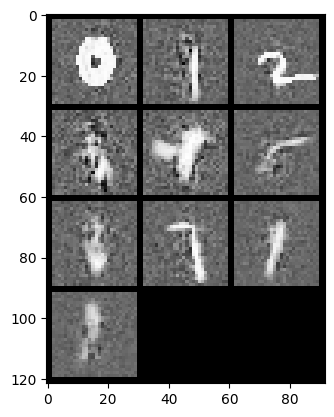

epoch: 941 g_loss: 8.231499671936035 d_loss: 0.0006518534695108732
epoch: 942 g_loss: 8.377378463745117 d_loss: 0.0020601718376080194
epoch: 943 g_loss: 9.163384437561035 d_loss: 0.0027537199979027114
epoch: 944 g_loss: 10.225521087646484 d_loss: 0.028833918273448944
epoch: 945 g_loss: 9.808235168457031 d_loss: 0.0013914726053675015
epoch: 946 g_loss: 9.050658226013184 d_loss: 0.00071954564191401
epoch: 947 g_loss: 9.966696739196777 d_loss: 0.002110037331779798
epoch: 948 g_loss: 9.574920654296875 d_loss: 0.00038517398449281853
epoch: 949 g_loss: 9.800017356872559 d_loss: 0.005763159443934758
epoch: 950 g_loss: 10.160531997680664 d_loss: 0.013375725597143173
epoch: 951 g_loss: 9.920318603515625 d_loss: 0.0007175832676390806
epoch: 952 g_loss: 9.562941551208496 d_loss: 0.004225739277899265
epoch: 953 g_loss: 9.284873962402344 d_loss: 0.00041320943273603916
epoch: 954 g_loss: 9.745749473571777 d_loss: 0.000387652893550694
epoch: 955 g_loss: 11.396402359008789 d_loss: 0.001168064773082733

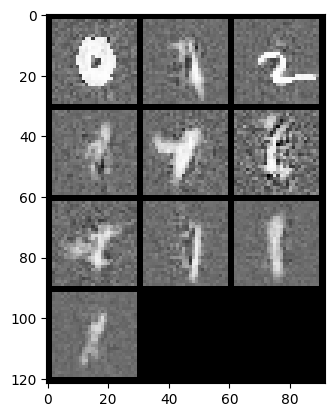

epoch: 961 g_loss: 9.04288101196289 d_loss: 0.002228498924523592
epoch: 962 g_loss: 12.226731300354004 d_loss: 0.0003840798744931817
epoch: 963 g_loss: 10.025827407836914 d_loss: 0.0009203644003719091
epoch: 964 g_loss: 9.724346160888672 d_loss: 0.02771454056104024
epoch: 965 g_loss: 10.604936599731445 d_loss: 0.026058383285999298
epoch: 966 g_loss: 10.386510848999023 d_loss: 0.0005913696950301528
epoch: 967 g_loss: 9.925568580627441 d_loss: 0.0033933169518907866
epoch: 968 g_loss: 8.977527618408203 d_loss: 0.000446501886472106
epoch: 969 g_loss: 10.238264083862305 d_loss: 0.025567904114723206
epoch: 970 g_loss: 8.645811080932617 d_loss: 0.0007525895877430836
epoch: 971 g_loss: 11.86806869506836 d_loss: 0.00015275595554461083
epoch: 972 g_loss: 8.673145294189453 d_loss: 0.0006833660881966352
epoch: 973 g_loss: 9.725049018859863 d_loss: 0.0008730070355037848
epoch: 974 g_loss: 9.089363098144531 d_loss: 0.006666854644815127
epoch: 975 g_loss: 10.854398727416992 d_loss: 0.0044722808524966

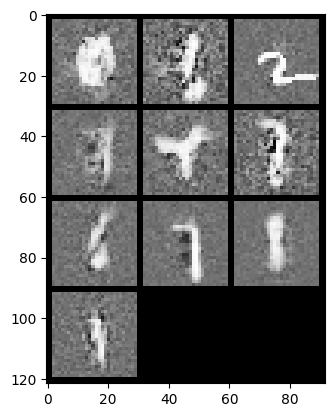

epoch: 981 g_loss: 10.977579116821289 d_loss: 0.00020602314422527948
epoch: 982 g_loss: 9.373945236206055 d_loss: 0.00026597660810997087
epoch: 983 g_loss: 9.223194122314453 d_loss: 0.012782654414574305
epoch: 984 g_loss: 11.197890281677246 d_loss: 0.0005019504266480604
epoch: 985 g_loss: 10.350240707397461 d_loss: 0.0010894432198256254
epoch: 986 g_loss: 8.45410442352295 d_loss: 0.003376265987753868
epoch: 987 g_loss: 10.686651229858398 d_loss: 0.0006589159990350405
epoch: 988 g_loss: 9.203095436096191 d_loss: 0.0008512261944512526
epoch: 989 g_loss: 9.292160034179688 d_loss: 0.0004895798629149795
epoch: 990 g_loss: 13.3533935546875 d_loss: 0.0025139471205572286
epoch: 991 g_loss: 12.268144607543945 d_loss: 0.020274887482325237
epoch: 992 g_loss: 10.190201759338379 d_loss: 0.00793848435084025
epoch: 993 g_loss: 9.176937103271484 d_loss: 0.001521905108044545
epoch: 994 g_loss: 9.239036560058594 d_loss: 0.005642292400201161
epoch: 995 g_loss: 10.002685546875 d_loss: 0.000725458919381102

In [16]:
num_epochs = 1000
n_critic = 3
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), real_images, labels)   
        g_loss = generator_train_step(len(real_images), real_images)
        
    print('epoch:', epoch, 'g_loss:', g_loss, 'd_loss:', (d_loss/n_critic))
    if epoch % 20 == 0:
        with torch.no_grad():
            generator.eval()
            z = Variable(torch.randn(10, 100)).cuda()
            labels = torch.LongTensor(np.arange(10)).cuda()
            sample_images = generator(z, labels).view(10,1,28,28).detach().cpu()
            grid = torchvision.utils.make_grid(sample_images, nrow=3, normalize=True)
            grid = grid.numpy().transpose(1, 2, 0)
            plt.imshow(grid, cmap=plt.get_cmap('gray'))
            plt.show()

In [9]:
torch.save(generator, './model_checkpoint/generator.pt')

NameError: name 'generator' is not defined

## Step5 Train cDCGAN

For this part, I implemented a conditional DCGAN for generating image.

In [21]:
class Generator_2(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, label_dim=10):
        super(Generator_2, self).__init__()
        # for random vector
        self.hidden_layer1 = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        # for label
        self.hidden_layer2 = nn.Sequential(
            nn.ConvTranspose2d(label_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.hidden_layer3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(128, output_dim, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1,h2], 1)
        h3 = self.hidden_layer3(x)
        out = self.output_layer(h3)
        return out

In [21]:
class Discriminator_2(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, label_dim=10):
        super(Discriminator_2, self).__init__()
        # for random vector
        self.hidden_layer1 = nn.Sequential(
            nn.Conv2d(input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        # for label
        self.hidden_layer2 = nn.Sequential(
            nn.Conv2d(label_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.output_layer = nn.Sequential(
            nn.Conv2d(512, output_dim, 3, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1,h2], 1)
        h3 = self.hidden_layer3(x)
        out = self.output_layer(h3)
        return out

In [22]:
label_dim = 10
image_size = 28
batch_size = 128
num_epochs = 100

In [23]:
# preparation
onehot = torch.zeros(label_dim, label_dim)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)

fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1

In [31]:
def d_train(real_img, labels, batch_size):
    D_optimizer.zero_grad()
    real_img = Variable(real_img.cuda())
    real_label = Variable(torch.ones(batch_size).cuda())
    fake_label = Variable(torch.zeros(batch_size).cuda())
    c_fill = Variable(fill[labels].cuda())
    
    # train with real images
    real_validity = D(real_img, c_fill).squeeze()
    real_loss = criterion(real_validity, real_label)

    # Train discriminator with fake data
    z = torch.randn(batch_size, 100).view(-1, 100, 1, 1)
    z = Variable(z.cuda())
    c = (torch.rand(batch_size, 1) * label_dim).type(torch.LongTensor).squeeze()
    c_onehot = Variable(onehot[c].cuda())
    fake_img = G(z, c_onehot)
    c_fill = Variable(fill[c].cuda())
    fake_validity = D(fake_img, c_fill).squeeze()
    fake_loss = criterion(fake_validity, fake_label)
    
    D_loss = real_loss + fake_loss
    # D.zero_grad()
    D_loss.backward()
    D_optimizer.step()
    return D_loss.item()

In [32]:
def g_train(batch_size):
    G_optimizer.zero_grad()
    real_label = Variable(torch.ones(batch_size).cuda())
    z = torch.randn(batch_size, 100).view(-1, 100, 1, 1)
    z = Variable(z.cuda())

    c = (torch.rand(batch_size, 1) * label_dim).type(torch.LongTensor).squeeze()
    c_onehot = Variable(onehot[c].cuda())
    gen_image = G(z, c_onehot)

    c_fill_ = Variable(fill[c].cuda())
    fake_validity = D(gen_image, c_fill_).squeeze()
    G_loss = criterion(fake_validity, real_label)

    # Back propagation
    # G.zero_grad()
    G_loss.backward()
    G_optimizer.step()
    return G_loss.item()

In [33]:
G = Generator_2().cuda()
D = Discriminator_2().cuda()

In [34]:
criterion = nn.BCELoss()
# setup optimizer
D_optimizer = optim.Adam(D.parameters(), lr=1e-5, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=1e-5, betas=(0.5, 0.999))
train_loader = DataLoader(aug_dataset(aug_data), batch_size=batch_size, shuffle=True)
train_loader_real = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

epoch:  0 g_loss:  1.0480440855026245 d_loss 0.8729957342147827


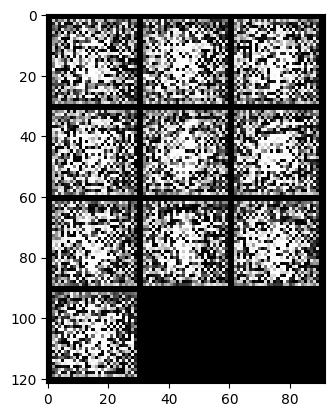

epoch:  1 g_loss:  1.3661704063415527 d_loss 0.5955396890640259
epoch:  2 g_loss:  1.9045703411102295 d_loss 0.3506239354610443
epoch:  3 g_loss:  2.083444595336914 d_loss 0.28547006845474243
epoch:  4 g_loss:  2.356293201446533 d_loss 0.2106436938047409
epoch:  5 g_loss:  2.7584195137023926 d_loss 0.1501094102859497
epoch:  6 g_loss:  2.557530164718628 d_loss 0.17091776430606842
epoch:  7 g_loss:  2.595431327819824 d_loss 0.16253380477428436
epoch:  8 g_loss:  2.87365984916687 d_loss 0.13210788369178772
epoch:  9 g_loss:  3.1087288856506348 d_loss 0.0825464203953743
epoch:  10 g_loss:  3.094743490219116 d_loss 0.08860675990581512


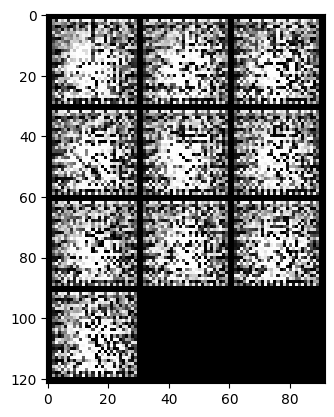

epoch:  11 g_loss:  3.2470195293426514 d_loss 0.09702607989311218
epoch:  12 g_loss:  2.90766978263855 d_loss 0.10866779834032059
epoch:  13 g_loss:  3.34539794921875 d_loss 0.06542697548866272
epoch:  14 g_loss:  3.164883613586426 d_loss 0.10979852080345154
epoch:  15 g_loss:  3.100703716278076 d_loss 0.09729135036468506
epoch:  16 g_loss:  2.793393611907959 d_loss 0.11641588807106018
epoch:  17 g_loss:  2.753593683242798 d_loss 0.16785043478012085
epoch:  18 g_loss:  2.177406072616577 d_loss 0.2965550422668457
epoch:  19 g_loss:  2.0232505798339844 d_loss 0.3560739755630493
epoch:  20 g_loss:  2.5147366523742676 d_loss 0.2981470823287964


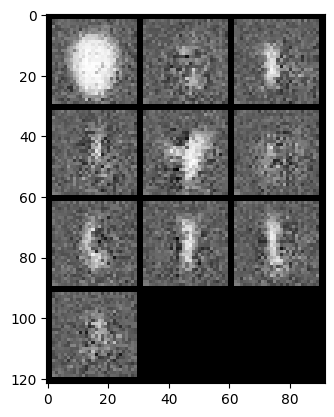

epoch:  21 g_loss:  2.440551519393921 d_loss 0.3086940050125122
epoch:  22 g_loss:  2.2924251556396484 d_loss 0.2570761740207672
epoch:  23 g_loss:  2.624415874481201 d_loss 0.24442705512046814
epoch:  24 g_loss:  2.5278077125549316 d_loss 0.2050533890724182
epoch:  25 g_loss:  2.668062686920166 d_loss 0.19515159726142883
epoch:  26 g_loss:  2.391871452331543 d_loss 0.2156897485256195
epoch:  27 g_loss:  2.8269753456115723 d_loss 0.16004051268100739
epoch:  28 g_loss:  3.081601142883301 d_loss 0.17290672659873962
epoch:  29 g_loss:  3.3487179279327393 d_loss 0.14289161562919617
epoch:  30 g_loss:  2.777697801589966 d_loss 0.1356550008058548


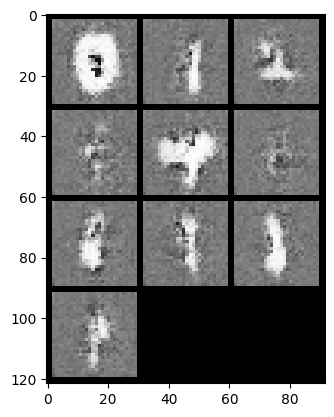

epoch:  31 g_loss:  2.9783525466918945 d_loss 0.10835877060890198
epoch:  32 g_loss:  3.189613103866577 d_loss 0.13619905710220337
epoch:  33 g_loss:  3.440890073776245 d_loss 0.10350970923900604
epoch:  34 g_loss:  2.7138850688934326 d_loss 0.12760908901691437
epoch:  35 g_loss:  3.1895740032196045 d_loss 0.09121974557638168
epoch:  36 g_loss:  3.440579414367676 d_loss 0.08455643057823181
epoch:  37 g_loss:  3.615070343017578 d_loss 0.07910408079624176
epoch:  38 g_loss:  3.6857786178588867 d_loss 0.065754733979702
epoch:  39 g_loss:  3.7977795600891113 d_loss 0.05972318351268768
epoch:  40 g_loss:  3.5976362228393555 d_loss 0.0514286532998085


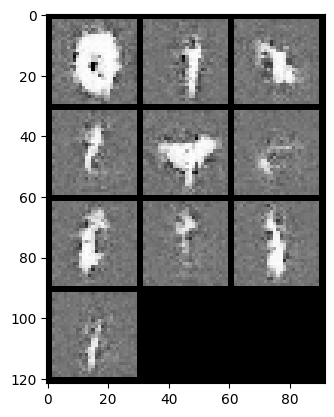

epoch:  41 g_loss:  3.725564479827881 d_loss 0.06828600913286209
epoch:  42 g_loss:  3.566514730453491 d_loss 0.050747230648994446
epoch:  43 g_loss:  3.8865108489990234 d_loss 0.057818908244371414
epoch:  44 g_loss:  4.125896453857422 d_loss 0.054847754538059235
epoch:  45 g_loss:  4.161638259887695 d_loss 0.05308094993233681
epoch:  46 g_loss:  3.923332929611206 d_loss 0.03874121606349945
epoch:  47 g_loss:  4.209306716918945 d_loss 0.03929886966943741
epoch:  48 g_loss:  4.376289367675781 d_loss 0.03801896795630455
epoch:  49 g_loss:  4.4488677978515625 d_loss 0.04063639044761658
epoch:  50 g_loss:  4.290157318115234 d_loss 0.034780606627464294


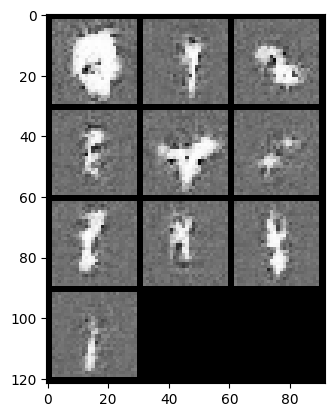

epoch:  51 g_loss:  4.193328857421875 d_loss 0.03035365417599678
epoch:  52 g_loss:  4.4360198974609375 d_loss 0.037093110382556915
epoch:  53 g_loss:  3.9348113536834717 d_loss 0.039350725710392
epoch:  54 g_loss:  4.465850830078125 d_loss 0.032208152115345
epoch:  55 g_loss:  5.043027877807617 d_loss 0.02218244969844818
epoch:  56 g_loss:  4.5467529296875 d_loss 0.03440575674176216
epoch:  57 g_loss:  4.316494464874268 d_loss 0.034023649990558624
epoch:  58 g_loss:  4.304455757141113 d_loss 0.027388032525777817
epoch:  59 g_loss:  4.323213577270508 d_loss 0.029282571747899055
epoch:  60 g_loss:  5.24364709854126 d_loss 0.02581903338432312


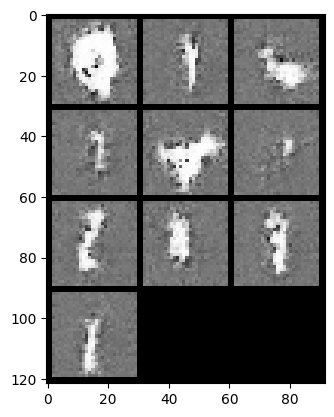

epoch:  61 g_loss:  4.683105945587158 d_loss 0.02642194554209709
epoch:  62 g_loss:  4.64503288269043 d_loss 0.02471506968140602
epoch:  63 g_loss:  5.107264518737793 d_loss 0.020783893764019012
epoch:  64 g_loss:  4.765087604522705 d_loss 0.019744757562875748
epoch:  65 g_loss:  5.155301094055176 d_loss 0.03109384886920452
epoch:  66 g_loss:  5.312351226806641 d_loss 0.023598965257406235
epoch:  67 g_loss:  4.861170768737793 d_loss 0.020264361053705215
epoch:  68 g_loss:  4.898993015289307 d_loss 0.01905672252178192
epoch:  69 g_loss:  5.024139881134033 d_loss 0.01706518977880478
epoch:  70 g_loss:  4.836225986480713 d_loss 0.016310209408402443


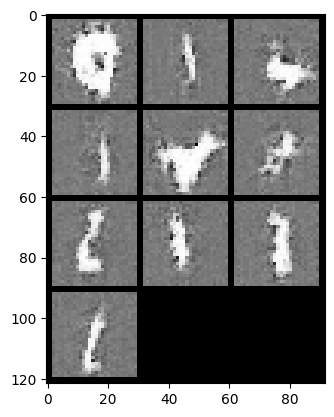

epoch:  71 g_loss:  4.842153072357178 d_loss 0.013255253434181213
epoch:  72 g_loss:  4.598223686218262 d_loss 0.011495430022478104
epoch:  73 g_loss:  5.609487533569336 d_loss 0.0157622117549181
epoch:  74 g_loss:  4.921174049377441 d_loss 0.014642827212810516
epoch:  75 g_loss:  5.108574867248535 d_loss 0.017279036343097687
epoch:  76 g_loss:  5.599360942840576 d_loss 0.011139800772070885
epoch:  77 g_loss:  5.019405841827393 d_loss 0.016517724841833115
epoch:  78 g_loss:  4.979045867919922 d_loss 0.011673666536808014
epoch:  79 g_loss:  5.298246383666992 d_loss 0.013505708426237106
epoch:  80 g_loss:  5.156235694885254 d_loss 0.012385965324938297


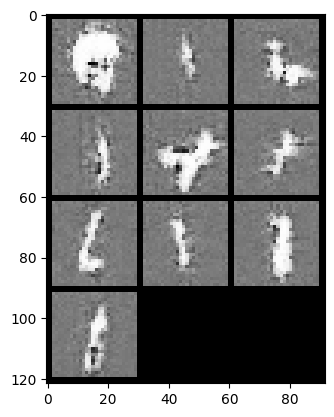

epoch:  81 g_loss:  5.4539079666137695 d_loss 0.012752769514918327
epoch:  82 g_loss:  5.090903282165527 d_loss 0.013480477035045624
epoch:  83 g_loss:  5.149247646331787 d_loss 0.014543886296451092
epoch:  84 g_loss:  5.268681526184082 d_loss 0.014810396358370781
epoch:  85 g_loss:  5.037383079528809 d_loss 0.01577259972691536
epoch:  86 g_loss:  5.272772312164307 d_loss 0.012593820691108704
epoch:  87 g_loss:  5.306999683380127 d_loss 0.01224804762750864
epoch:  88 g_loss:  5.112434387207031 d_loss 0.013612376525998116
epoch:  89 g_loss:  5.188938140869141 d_loss 0.014883032999932766
epoch:  90 g_loss:  5.086544990539551 d_loss 0.013435635715723038


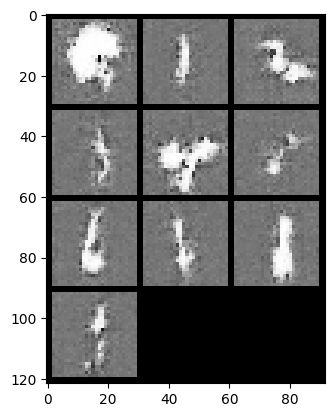

epoch:  91 g_loss:  5.6548614501953125 d_loss 0.011943859979510307
epoch:  92 g_loss:  5.560859203338623 d_loss 0.011908188462257385
epoch:  93 g_loss:  5.85345458984375 d_loss 0.011411074548959732
epoch:  94 g_loss:  5.77694034576416 d_loss 0.011794534511864185
epoch:  95 g_loss:  5.632043361663818 d_loss 0.012302636168897152
epoch:  96 g_loss:  5.175138473510742 d_loss 0.008246914483606815
epoch:  97 g_loss:  5.75163459777832 d_loss 0.010499853640794754
epoch:  98 g_loss:  5.108972549438477 d_loss 0.009891968220472336
epoch:  99 g_loss:  6.057164192199707 d_loss 0.005430682562291622


In [35]:
g_losses = []
d_losses = []
n_critic = 3
for epoch in range(num_epochs):
#     if epoch == 5 or epoch == 10:
#         G_optimizer.param_groups[0]['lr'] /= 2
#         D_optimizer.param_groups[0]['lr'] /= 2
    for _,data in enumerate(train_loader):
        img, label = data
        d_loss = d_train(img, label,len(img))
        g_loss = g_train(len(img))
        g_losses.append(g_loss)
        d_losses.append(d_loss)
    print("epoch: ", epoch, "g_loss: ", g_loss, "d_loss", d_loss)
    if epoch %10 == 0:
        with torch.no_grad():
            labels = torch.tensor([0,1,2,3,4,5,6,7,8,9]).view(10,1)
            z_ = torch.randn(10, 100).view(-1, 100, 1, 1)
            z_ = Variable(z_.cuda())

            c_ = (labels).type(torch.LongTensor).squeeze()
            c_onehot_ = Variable(onehot[c_].cuda())
            gen_image = G(z_, c_onehot_).detach().cpu()
            grid = torchvision.utils.make_grid(gen_image, nrow=3, normalize=True)
            grid = grid.numpy().transpose(1, 2, 0)
            plt.imshow(grid, cmap=plt.get_cmap('gray'))
            plt.show()

In [38]:
torch.save(G, './model_checkpoint/generator2_B.pt')

/nas/home/duyongka/.conda/envs/async/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator_2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Step6 Load Models and Generate Images

In [25]:
# WGAN is trained in another file
WG = torch.load(('./model_checkpoint/Wgenerator.pt'))
# cDCGAN
G = torch.load('./model_checkpoint/generator2.pt')
# cGAN
generator = torch.load('./model_checkpoint/generator.pt')

In [26]:
# generate image for training
num = 1024
with torch.no_grad():
    generator = generator.cuda()
    rand_int = np.random.randint(0,10,size=num)
    labels = torch.LongTensor(rand_int).cuda()
    z = Variable(torch.randn(num, 100)).cuda()
    gen_image = generator(z, labels).view(num,1,28,28).detach().cpu()

generate_data3 = []
for i in range(num):
    generate_data3.append([gen_image[i],rand_int[i]])

In [27]:
with torch.no_grad():
    #for i in range(1):
    rand_int = np.random.randint(0,10,size=num)
    labels = torch.LongTensor(rand_int).view(num,1)
    #labels = torch.tensor([0,1,2,3,4,5,6,7,8,9]).view(10,1)
    z_ = torch.randn(num, 100).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda())

    c_ = (labels).type(torch.LongTensor).squeeze()
    c_onehot_ = Variable(onehot[c_].cuda())
    gen_image = G(z_, c_onehot_).detach().cpu()


generate_data2 = []
for i in range(num):
    generate_data2.append([gen_image[i],rand_int[i]])

In [28]:
with torch.no_grad():
    generator = generator.cuda()
    rand_int = np.random.randint(0,10,size=num)
    labels = torch.LongTensor(rand_int).cuda()
    z = Variable(torch.randn(num, 100)).cuda()
    gen_image = generator(z, labels).view(num,1,28,28).detach().cpu()

generate_data = []
for i in range(num):
    generate_data.append([gen_image[i],rand_int[i]])

## Step7 Train and test second FFN

In this part, I trained another FFN for image classification with only one original images aviliable for each class

Adding L1 loss between model output and real logit, the model has 0.1 improvment on AUC.

Augmentated data + CGAN + Convolutional CGAN + WGAN : 0.81 (ACC), 0.94(AUC)

In [29]:
# dataset with only augmented data
class aug_dataset(Dataset):
    def __init__(self,aug_data_list):
        self.aug_data_list = aug_data_list
    def __getitem__(self, idx):
        img = self.aug_data_list[idx][0]
        label = self.aug_data_list[idx][1]
        return img, label
    def __len__(self):
        return len(self.aug_data_list)

# dataset with data from three methods 
class gen_dataset(Dataset):
    def __init__(self,aug_data_list, generate_data1, generate_data2, generate_data3):
        self.data_list = aug_data_list + generate_data1 + generate_data2 + generate_data3
        
    def __getitem__(self, idx):
        img = self.data_list[idx][0]
        label = self.data_list[idx][1]
        return img, label
    def __len__(self):
        return len(self.data_list)

In [46]:
"""Train a model from strach or with a trained model"""
model=resnet18.cuda()
# model = torch.load('./model_checkpoint/Second_ResNet.pt').cuda()
"""Adam can lead to better results but with issue that acc suddendly decrease"""
optimizer=torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer=torch.optim.SGD(model.parameters(), lr=0.03, weight_decay= 1e-6, momentum = 0.9,nesterov = True)
criterion=nn.CrossEntropyLoss()
Logit_loss = nn.L1Loss()
train_loader = DataLoader(gen_dataset(aug_data, generate_data, generate_data2, generate_data3), batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [49]:
epochs = 100
train_losses, test_acc, test_auc = [], [], []
for epoch in range(epochs):
    """Apply adaptive learning rate policy"""
#     if epoch == 5:
#         optimizer.param_groups[0]['lr'] /= 2
    for _,data in enumerate(train_loader):
        # adjust learning rate
        model.train()
        img, labels = data
        img = img.cuda()
        labels = labels.cuda()
        y_pre, prob = model(img)
        loss = 0.
        loss += criterion(y_pre,labels)
        # add logit_loss
        logit_loss = 0.
        logit_label = []
        for i in range(len(labels)):
            logit_label.append(selected_logits[labels[i]][0].detach().tolist())
        logit_loss = Logit_loss(y_pre, torch.Tensor(logit_label).cuda())
        loss += logit_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(loss.item())
    with torch.no_grad():
        sum_auc = 0.
        model.eval()
        total = len(test_dataset)
        correct = 0
        for _,(img,labels) in enumerate(test_loader):
            imgs = img.cuda()
            labels = labels.cuda()
            logits, probas = model(imgs)
            _, predicted_labels = torch.max(probas, 1)
            correct += (predicted_labels == labels).sum()
            # compute AUC
            logits = torch.nn.functional.softmax(logits, dim=1)
            logits = logits.tolist()
            labels = labels.tolist()
            auc = roc_auc_score(y_true=labels, y_score=logits, multi_class='ovo', labels=[i for i in range(10)])
            sum_auc += auc
        test_acc.append(correct.item()/total)
        test_auc.append(sum_auc/len(test_loader))
        print('epoch: {}'.format(epoch),
              'training loss: {}'.format(loss.item()),
              'testing acc: {}'.format(correct.item()/total),
              'testing auc: {}'.format(sum_auc/len(test_loader))
             )     

epoch: 0 training loss: 0.03362838551402092 testing acc: 0.8 testing auc: 0.945009669567747
epoch: 1 training loss: 0.025759343057870865 testing acc: 0.8088 testing auc: 0.9443453403027641
epoch: 2 training loss: 0.025379890576004982 testing acc: 0.8106 testing auc: 0.9470222295890592
epoch: 3 training loss: 0.023315107449889183 testing acc: 0.8039 testing auc: 0.9435626629838949
epoch: 4 training loss: 0.030245209112763405 testing acc: 0.8085 testing auc: 0.9448682630864158
epoch: 5 training loss: 0.030583132058382034 testing acc: 0.8064 testing auc: 0.9455865044167782
epoch: 6 training loss: 0.028269249945878983 testing acc: 0.8124 testing auc: 0.9450028567409305
epoch: 7 training loss: 0.030476808547973633 testing acc: 0.8097 testing auc: 0.9467899758770828
epoch: 8 training loss: 0.036241669207811356 testing acc: 0.8085 testing auc: 0.942207258219869
epoch: 9 training loss: 0.05327736213803291 testing acc: 0.8043 testing auc: 0.9464032812964874
epoch: 10 training loss: 0.0306937526

epoch: 85 training loss: 0.024308763444423676 testing acc: 0.7871 testing auc: 0.9425821101865938
epoch: 86 training loss: 0.03073778562247753 testing acc: 0.789 testing auc: 0.9419420192921995
epoch: 87 training loss: 0.022003857418894768 testing acc: 0.7898 testing auc: 0.9406635624264997
epoch: 88 training loss: 0.023989899083971977 testing acc: 0.7913 testing auc: 0.9410974903029253
epoch: 89 training loss: 0.0163121335208416 testing acc: 0.7942 testing auc: 0.9410535422502676
epoch: 90 training loss: 0.032168593257665634 testing acc: 0.794 testing auc: 0.9411520085400191
epoch: 91 training loss: 0.024897858500480652 testing acc: 0.7945 testing auc: 0.9434759945597989
epoch: 92 training loss: 0.04209411144256592 testing acc: 0.7985 testing auc: 0.9453810303496797
epoch: 93 training loss: 0.024425487965345383 testing acc: 0.799 testing auc: 0.9446584451683838
epoch: 94 training loss: 0.04568422958254814 testing acc: 0.7978 testing auc: 0.9437738525932793
epoch: 95 training loss: 0.0

In [108]:
torch.cuda.empty_cache()

In [51]:
import matplotlib.pyplot as plt
def plot(list_x, list_y, name):
    plt.plot(list_x, list_y, 'v-', label=name)
    plt.xlabel('epoch')
    plt.ylabel(name)
    plt.legend()
    plt.show()

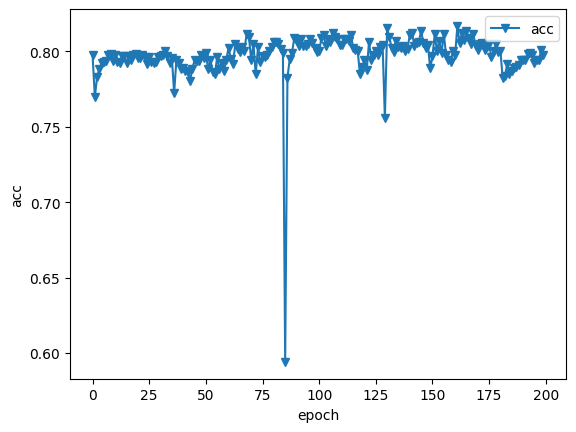

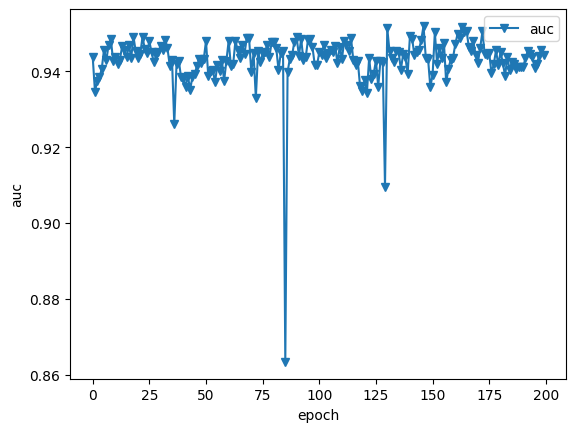

highest acc:  0.8169
highest auc:  0.9519758513261567


In [55]:
epoch_list = [i for i in range(len(test_acc))]
plot(epoch_list, test_acc, 'acc')
plot(epoch_list, test_auc, 'auc')
print("highest acc: ", max(test_acc))
print("highest auc: ", max(test_auc))

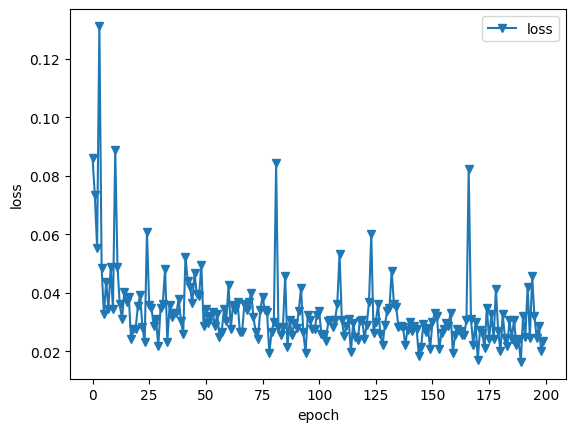

In [53]:
epoch_list = [i for i in range(len(train_losses))]
plot(epoch_list, train_losses, 'loss')

In [48]:
torch.save(model, './model_checkpoint/Second_ResNet.pt')

/nas/home/duyongka/.conda/envs/async/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/nas/home/duyongka/.conda/envs/async/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
